In [14]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import pickle as pk
import torch

from tqdm.notebook import tqdm
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

---

## Load DrugBank

In [16]:
def morgan_fingerprint(mol,radius=2,nbits=2048):
    return torch.from_numpy(np.array(AllChem.GetMorganFingerprintAsBitVect(mol,radius,nbits)))

In [17]:
molecules = Chem.SDMolSupplier('/afs/csail.mit.edu/u/s/samsl/Work/databases/DrugBank/all_structures.sdf')
moleculeDict = {m.GetProp('DRUGBANK_ID'): m for m in molecules if m is not None}

[15:34:13] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[15:34:13] ERROR: Could not sanitize molecule ending on line 289199
[15:34:13] ERROR: Explicit valence for atom # 13 Cl, 5, is greater than permitted
[15:34:13] Explicit valence for atom # 19 O, 3, is greater than permitted
[15:34:13] ERROR: Could not sanitize molecule ending on line 399275
[15:34:13] ERROR: Explicit valence for atom # 19 O, 3, is greater than permitted
[15:34:13] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:34:13] ERROR: Could not sanitize molecule ending on line 522730
[15:34:13] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[15:34:13] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:34:13] ERROR: Could not sanitize molecule ending on line 578040
[15:34:13] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[15:34:13] Explicit valence for atom # 12 N, 4, is greater than permitted
[15:34:13] ERROR: Could not sanitize

In [18]:
import xml.etree.ElementTree as ET
full_drugbank = ET.parse('/afs/csail.mit.edu/u/s/samsl/Work/databases/DrugBank/full_database.xml')
drugbank_root = full_drugbank.getroot()
namespaces = {'drugbank': 'http://www.drugbank.ca'}

In [19]:
class ATC_Code:
    def __init__(self, xmlcode):
        self.code = c.attrib["code"]
        self.lvls = xmlcode.findall("drugbank:level",namespaces)
        self.lvl4 = (self.lvls[0].attrib["code"], self.lvls[0].text)
        self.lvl3 = (self.lvls[1].attrib["code"], self.lvls[1].text)
        self.lvl2 = (self.lvls[2].attrib["code"], self.lvls[2].text)
        self.lvl1 = (self.lvls[3].attrib["code"], self.lvls[3].text)
        
    def __repr__(self):
        return f"{self.code} ({self.lvl1[1]}, {self.lvl2[1]}, {self.lvl3[1]}, {self.lvl4[1]})"
    
    def __eq__(self, other):
        return self.code == other.code
    
class Drug:
    def __init__(self, dbid, smiles, codes):
        self.name = dbid
        self.smiles = smiles
        self.codes = codes
        
        self.embeddings = {}

    def __repr__(self):
        return f"{self.name}: {[i for i in self.codes]}"
        
    def __eq__(self, other):
        return self.name == other.name

    def setRDKitMol(self,m):
        self.rdkitmol = m
        
    def getRDKitMol(self):
        return self.rdkitmol
        
    def setEmbedding(self,embName,embedding):
        self.embeddings[embName] = embedding
        
    def getEmbedding(self,embName):
        return self.embeddings[embName]

In [20]:
drugDict = {}

for drxml in tqdm(drugbank_root, total=len(drugbank_root)):
    dbid = drxml.find('drugbank:drugbank-id[@primary="true"]',namespaces).text
    if dbid in moleculeDict.keys():
        codesxml = drxml.findall('drugbank:atc-codes/drugbank:atc-code', namespaces)
        codesclass = []
        for c in codesxml:
            codesclass.append(ATC_Code(c))
        drclass = Drug(dbid, moleculeDict[dbid].GetProp('SMILES'), codesclass)
        drugDict[dbid] = drclass
    else:
        continue

  0%|          | 0/14594 [00:00<?, ?it/s]

In [21]:
print(len(drugDict),'drugs from DrugBank')

11290 drugs from DrugBank


In [22]:
drugDict['DB00006']

DB00006: [B01AE06 (BLOOD AND BLOOD FORMING ORGANS, ANTITHROMBOTIC AGENTS, ANTITHROMBOTIC AGENTS, Direct thrombin inhibitors)]

In [23]:
topLvlClasses = {}

for k,v in drugDict.items():
    if len(v.codes):
        topLvlClasses[k] = v.codes[0].lvl1[0]
    else:
        topLvlClasses[k] = '-'

In [24]:
from collections import Counter
cntr = Counter(topLvlClasses.values())
cntr

Counter({'B': 94,
         'L': 231,
         'R': 201,
         'H': 42,
         '-': 8447,
         'J': 305,
         'A': 329,
         'V': 152,
         'G': 163,
         'D': 174,
         'N': 478,
         'S': 98,
         'M': 138,
         'C': 345,
         'P': 93})

---

## Load Surfaceome

In [25]:
tdb = pd.read_excel('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/table_S3_surfaceome.xlsx')
tdb.columns = tdb.iloc[0]

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [26]:
surface_db = tdb[tdb['Surfaceome Label'] == 'surface']

In [27]:
surface_db.columns

Index(['UniProt name', 'UniProt accession', 'UniProt description',
       'UniProt gene', 'Surfaceome Label', 'Surfaceome Label Source',
       'Comment', 'length', 'TM domains', 'signalpeptide', 'topology',
       'topology source', 'MachineLearning trainingset',
       'MachineLearning score',
       'MachineLearning FPR class (1=1%, 2=5%, 3=15%)', 'Ensembl gene',
       'Ensembl protein', 'CD number', 'Membranome Almen main-class',
       'Membranome Almen sub-class', 'nxst motifs', 'noncyt. nxst count',
       'peps with accessible noncyt. nxst', 'noncyt. Trp count',
       'peps with accessible noncyt. Trp', 'noncyt. Tyr count',
       'peps with accessible noncyt. Tyr', 'glycomineN sites',
       'glycomineO sites', 'glycomineC sites', 'CSPA category',
       'CSPA peptide count', 'CSPA peptides', 'CSPA N115 sites', 'CSPA id',
       'UniProt subcellular', 'UniProt keywords', 'UniProt uniref',
       'COMPARTMENTS link', 'COMPARTMENTS benchmark pos',
       'COMPARTMENTS benchmar

In [28]:
surface_db[['UniProt accession', 'Ensembl gene','length','TM domains','Membranome Almen main-class','UniProt subcellular']]

,UniProt accession,Ensembl gene,length,TM domains,Membranome Almen main-class,UniProt subcellular
2217,A0AV02,ENSG00000221955,714,13,Transporters,Membrane (Multi-pass membrane protein)
2218,A0FGR9,ENSG00000158220,886,2,Unclassified,Cell membrane (Peripheral membrane protein);En...
2219,A0PJK1,ENSG00000154025,596,14,Transporters,Cell membrane (Multi-pass membrane protein)
2220,A0PK11,ENSG00000249581,232,4,Unclassified,Membrane (Multi-pass membrane protein)
2221,A0ZSE6,ENSG00000235156,113,1,Miscellaneous,Membrane (Single-pass membrane protein)
...,...,...,...,...,...,...
5098,Q9Y6N8,ENSG00000040731,788,1,Miscellaneous,Cell membrane (Single-pass type I membrane pro...
5099,Q9Y6Q6,ENSG00000141655,616,1,Receptors,Cell membrane (Single-pass type I membrane pro...
5100,Q9Y6R1,ENSG00000080493,1079,10,Transporters,Basolateral cell membrane (Multi- pass membran...
5101,Q9Y6W8,ENSG00000163600,199,1,Unclassified,Cell membrane (Single-pass type I membrane pro...


In [29]:
### Write list of sequences

with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surface_uniprot_list.txt','w+') as f:
    for p in surface_db['UniProt accession'].to_list():
        f.write(f"{p}\n")
        
### Download these sequences from UniProt

In [30]:
updb = pd.read_csv('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_download.tsv',sep='\t')
updb = updb[~updb['Sequence'].isna()]

In [31]:
updb.head()

,Entry,Protein names,Gene names,Organism,Length,Sequence,EC number,Cross-reference (Pfam),Cross-reference (BindingDB),Cross-reference (DrugBank)
0,A0AV02,Solute carrier family 12 member 8 (Cation-chlo...,SLC12A8 CCC9,Homo sapiens (Human),714.0,MTQMSQVQELFHEAAQQDALAQPQPWWKTQLFMWEPVLFGTWDGVF...,NaN,PF00324;,NaN,NaN
1,A0FGR9,Extended synaptotagmin-3 (E-Syt3) (Chr3Syt),ESYT3 FAM62C,Homo sapiens (Human),886.0,MRAEEPCAPGAPSALGAQRTPGPELRLSSQLLPELCTFVVRVLFYL...,NaN,PF00168;PF17047;,NaN,NaN
2,A0PJK1,Sodium/glucose cotransporter 5 (Na(+)/glucose ...,SLC5A10 SGLT5,Homo sapiens (Human),596.0,MAANSTSDLHTPGTQLSVADIIVITVYFALNVAVGIWSSCRASRNT...,NaN,PF00474;,NaN,NaN
3,A0PK11,Clarin-2,CLRN2,Homo sapiens (Human),232.0,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,NaN,NaN,NaN,NaN
4,A0ZSE6,Cell cycle control protein 50C (Transmembrane ...,TMEM30CP CDC50C TMEM30C,Homo sapiens (Human),113.0,MEERAQHCLSRLLDNSALKQQELPIHRLYFTARRVLFVFFATGIFC...,NaN,NaN,NaN,NaN


In [32]:
mrgdb = pd.merge(surface_db, updb, left_on='UniProt accession', right_on='Entry',how='inner')

In [33]:
mrgdb.to_csv('/afs/csail/u/s/samsl/Work/databases/surfaceome/surfaceome_merged_db.tsv',sep='\t',index=False)

In [20]:
with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_seqs.fasta','w+') as f:
    for i,r in mrgdb.iterrows():
        f.write(f">{r.Entry}\n{r.Sequence}\n")

### Domain Annotation

In [34]:
#!/scratch1/rsingh/tools/bin/hmmscan -o /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.out --tblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.tblout --domtblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.domtblout --acc --noali --notextw --cut_ga /afs/csail.mit.edu/u/r/rsingh/work/corals/data/raw/pfam/Pfam-A.hmm /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_seqs.fasta 

In [35]:
from Bio.SearchIO.HmmerIO.hmmer3_tab import Hmmer3TabParser

In [36]:
with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.tblout','r') as f:
    hmmerhits = list(Hmmer3TabParser(f))

In [37]:
domtbl = []

for rec in hmmerhits:
    for hit in rec.hits:
        domtbl.append((rec.id, hit.id, hit.accession, hit.evalue, hit.bitscore))
        
domtbl = pd.DataFrame(domtbl,columns=['Query','DomName','DomAccession','eval','bitscore'])

In [38]:
grpdomtbl = domtbl.groupby('Query')['DomName','DomAccession'].transform(lambda x: ','.join(x))
grpdomtbl.index = domtbl.Query
grpdomtbl = grpdomtbl.reset_index().drop_duplicates()

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [39]:
full_dom_db = pd.merge(mrgdb,grpdomtbl,left_on='Entry', right_on='Query', how='inner')
full_dom_db = full_dom_db.set_index('UniProt accession')
full_dom_db.head()

,UniProt name,UniProt description,UniProt gene,Surfaceome Label,Surfaceome Label Source,Comment,length,TM domains,signalpeptide,topology,...,Organism,Length,Sequence,EC number,Cross-reference (Pfam),Cross-reference (BindingDB),Cross-reference (DrugBank),Query,DomName,DomAccession
UniProt accession,,,,,,,,,,,,,,,,,,,,,
A0AV02,S12A8_HUMAN,Solute carrier family 12 member 8,SLC12A8,surface,machine learning,NaN,714,13,0,NC:1-37;TM:38-60;CY:61-71;TM:72-93;NC:94-98;TM...,...,Homo sapiens (Human),714.0,MTQMSQVQELFHEAAQQDALAQPQPWWKTQLFMWEPVLFGTWDGVF...,NaN,PF00324;,NaN,NaN,A0AV02,AA_permease,PF00324.22
A0FGR9,ESYT3_HUMAN,Extended synaptotagmin-3,ESYT3,surface,pos. trainingset,NaN,886,2,0,CY:1-27;TM:28-46;NC:47-51;TM:52-72;CY:73-886,...,Homo sapiens (Human),886.0,MRAEEPCAPGAPSALGAQRTPGPELRLSSQLLPELCTFVVRVLFYL...,NaN,PF00168;PF17047;,NaN,NaN,A0FGR9,"SMP_LBD,C2","PF17047.6,PF00168.31"
A0PJK1,SC5AA_HUMAN,Sodium/glucose cotransporter 5,SLC5A10,surface,machine learning,NaN,596,14,0,NC:1-15;TM:16-37;CY:38-73;TM:74-93;NC:94-98;TM...,...,Homo sapiens (Human),596.0,MAANSTSDLHTPGTQLSVADIIVITVYFALNVAVGIWSSCRASRNT...,NaN,PF00474;,NaN,NaN,A0PJK1,SSF,PF00474.18
A1A5B4,ANO9_HUMAN,Anoctamin-9,ANO9,surface,pos. trainingset,NaN,782,8,0,CY:1-195;TM:196-217;NC:218-266;TM:267-285;CY:2...,...,Homo sapiens (Human),782.0,MQGEESLRILVEPEGDSFPLMEISTCETEASEQWDYVLVAQRHTQR...,NaN,PF04547;,NaN,NaN,A1A5B4,"Anoctamin,Anoct_dimer","PF04547.13,PF16178.6"
A1A5C7,S22AN_HUMAN,Solute carrier family 22 member 23,SLC22A23,surface,machine learning,NaN,686,10,0,NC:1-230;TM:231-253;CY:254-258;TM:259-280;NC:2...,...,Homo sapiens (Human),686.0,MAIDRRREAAGGGPGRQPAPAEENGSLPPGDAAASAPLGGRAGPGG...,NaN,PF00083;,NaN,NaN,A1A5C7,"Sugar_tr,MFS_1","PF00083.25,PF07690.17"


## How well documented is this target?

In [27]:
import requests, json

In [28]:
def get_tdl_novelty(pid):
    url = 'https://pharos-api.ncats.io/graphql'
    query = {'query': 'query targetDetails{target(q:{sym:"' + pid + '"}) {name tdl fam sym description novelty}}'}
    r = requests.post(url, json=query)
    assert r.status_code==200
    json_d = json.loads(r.text)
    tdl = json_d['data']['target']['tdl']
    nov = json_d['data']['target']['novelty']
    return tdl, nov
    

In [30]:
# novelty_db = {}
# for x in tqdm(full_dom_db.index,total=len(full_dom_db)):
#     novelty_db[x] = get_tdl_novelty(x)

In [32]:
# get_tdl_novelty('A1A5C7')

---

# Project into common space

In [40]:
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
from src.architectures import SimpleCoembedding

In [41]:
# Load model
device = torch.device(6)
mol_f = MorganFeaturizer().cuda(device)
prot_f = ProtBertFeaturizer().cuda(device)
model = SimpleCoembedding(mol_f.shape, prot_f.shape, 1024)
model.load_state_dict(torch.load("../best_models/ProdModels/prod_within_state.pt"))
# model = torch.load("../best_models/BindingDB_ProtBert_Morgan_progressiveMargin_DUDeWithin_best_model.sav").to(torch.device(6))

<All keys matched successfully>

In [42]:
model = model.to(device)

In [43]:
prot_names = []
prot_domains = []
prot_projections = []
mol_names = []
mol_projections = []

with torch.set_grad_enabled(False):
    for _, r in tqdm(full_dom_db.iterrows(),total=len(full_dom_db)):
        seq = r.Sequence
        seqName = r.Query
        # prot_emb = prot_f(seq).unsqueeze(0)
        # prot_proj = model.target_projector(prot_emb).squeeze().detach().cpu().numpy()
        # prot_proj = model.prot_projector(prot_emb).squeeze().detach().cpu().numpy()
        prot_names.append(seqName)
        prot_domains.append(r.DomAccession)
        # prot_projections.append(prot_proj)

    for molName, mol in tqdm(moleculeDict.items(),total=len(moleculeDict)):
        # mol_emb = mol_f(Chem.MolToSmiles(mol)).unsqueeze(0)
        # mol_proj = model2.drug_projector(mol_emb).squeeze().detach().cpu().numpy()
        # mol_proj = model.mol_projector(mol_emb).squeeze().detach().cpu().numpy()
        mol_names.append(molName)
        # mol_projections.append(mol_proj)

  0%|          | 0/2716 [00:00<?, ?it/s]

  0%|          | 0/11290 [00:00<?, ?it/s]

In [44]:
protbert_embs = {}

for _,r in tqdm(full_dom_db.iterrows(),total=len(full_dom_db)):
    protbert_embs[r.Query] = prot_f(r.Sequence).detach().cpu().numpy()
    
protbert_np = np.stack(protbert_embs.values())

  0%|          | 0/2716 [00:00<?, ?it/s]

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [45]:
# all_embeddings = np.concatenate([mol_projections,prot_projections],axis=0)
# pk.dump(all_embeddings,open(f'{DATA_DIR}/protbert_morgan_drugbank_x_surfaceome_embeddings_20220905.pk','wb'))

all_embeddings = pk.load(open(f'{DATA_DIR}/protbert_morgan_drugbank_x_surfaceome_embeddings.pk','rb')).squeeze()
# all_embeddings = pk.load(open(f'{DATA_DIR}/protbert_morgan_drugbank_x_surfaceome_embeddings_20220707.pk','rb')).squeeze()
mol_projections = all_embeddings[:len(moleculeDict)]
prot_projections = all_embeddings[-len(full_dom_db):]

In [39]:
# pp_dict = {i: j for (i,j) in zip(full_dom_db.index, prot_projections)}
# mp_dict = {i: j for (i,j) in zip(moleculeDict.keys(), mol_projections)}

In [40]:
# pk.dump(mp_dict,open(f'{DATA_DIR}/pb_morgan_drugbank_embeddings_202209205.pk','wb'))
# pk.dump(pp_dict,open(f'{DATA_DIR}/pb_morgan_surfaceome_embeddings_20220905.pk','wb'))
# mp_dict = pk.load(open(f'{DATA_DIR}/pb_morgan_drugbank_embeddings_20220829.pk','rb'))
# pp_dict = pk.load(open(f'{DATA_DIR}/pb_morgan_surfaceome_embeddings_20220829.pk','rb'))

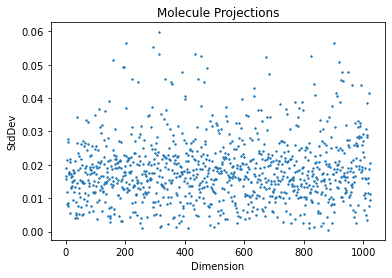

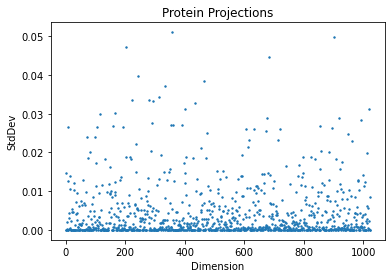

In [46]:
plt.scatter(np.arange(1024), mol_projections.squeeze().std(axis=0),s=2)
plt.title('Molecule Projections')
plt.xlabel('Dimension')
plt.ylabel('StdDev')
plt.show()

plt.scatter(np.arange(1024), prot_projections.squeeze().std(axis=0),s=2)
plt.title('Protein Projections')
plt.xlabel('Dimension')
plt.ylabel('StdDev')
plt.show()

In [47]:
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [48]:
mol_projections = np.stack(mol_projections).squeeze()
prot_projections = np.stack(prot_projections).squeeze()
all_embeddings = np.concatenate([prot_projections, mol_projections])

In [49]:
# embed_kpca = KernelPCA(kernel="cosine").fit_transform(all_embeddings)
embed_tsne = TSNE(metric="cosine",random_state=61998).fit_transform(all_embeddings)
protbert_tsne = TSNE(metric="cosine",random_state=61998).fit_transform(protbert_np)

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/

In [45]:
# embed_umap = UMAP(metric="cosine").fit_transform(all_embeddings)

---

# Visualize space by categories

In [50]:
full_dom_db[full_dom_db.DomAccession.str.contains('PF00069.26')][['UniProt name', 'UniProt gene', 'DomName', 'DomAccession']]

,UniProt name,UniProt gene,DomName,DomAccession
UniProt accession,,,,
O15146,MUSK_HUMAN,MUSK,"PK_Tyr_Ser-Thr,I-set,Ig_3,Pkinase,Ig_2,ig,Fz,C...","PF07714.18,PF07679.17,PF13927.7,PF00069.26,PF1..."
O15197,EPHB6_HUMAN,EPHB6,"PK_Tyr_Ser-Thr,Ephrin_lbd,Pkinase,fn3,SAM_2,Ep...","PF07714.18,PF01404.20,PF00069.26,PF00041.22,PF..."
P00533,EGFR_HUMAN,EGFR,"PK_Tyr_Ser-Thr,Recep_L_domain,GF_recep_IV,Pkin...","PF07714.18,PF01030.25,PF14843.7,PF00069.26,PF0..."
P04626,ERBB2_HUMAN,ERBB2,"PK_Tyr_Ser-Thr,Recep_L_domain,GF_recep_IV,Pkin...","PF07714.18,PF01030.25,PF14843.7,PF00069.26,PF0..."
P04629,NTRK1_HUMAN,NTRK1,"PK_Tyr_Ser-Thr,Pkinase,TPKR_C2,I-set,LRR_8,Trk...","PF07714.18,PF00069.26,PF16920.6,PF07679.17,PF1..."
...,...,...,...,...
Q16832,DDR2_HUMAN,DDR2,"PK_Tyr_Ser-Thr,Pkinase,F5_F8_type_C","PF07714.18,PF00069.26,PF00754.26"
Q5JZY3,EPHAA_HUMAN,EPHA10,"PK_Tyr_Ser-Thr,Ephrin_lbd,Pkinase,fn3,SAM_1,SA...","PF07714.18,PF01404.20,PF00069.26,PF00041.22,PF..."
Q8NER5,ACV1C_HUMAN,ACVR1C,"PK_Tyr_Ser-Thr,Pkinase,TGF_beta_GS,Activin_recp","PF07714.18,PF00069.26,PF08515.13,PF01064.24"


In [51]:
full_dom_db[full_dom_db.DomAccession.str.contains('PF00069.26')][['UniProt name', 'UniProt gene', 'DomName', 'DomAccession']]['UniProt gene'].values

array(['MUSK', 'EPHB6', 'EGFR', 'ERBB2', 'NTRK1', 'INSR', 'CSF1R', 'RET',
       'IGF1R', 'MET', 'ROS1', 'PDGFRB', 'KIT', 'FGFR1', 'INSRR', 'NPR1',
       'PDGFRA', 'FLT1', 'NPR2', 'EPHA1', 'FGFR2', 'ERBB3', 'FGFR4',
       'FGFR3', 'GUCY2C', 'ACVR2A', 'EPHA2', 'EPHA3', 'EPHA8', 'EPHB2',
       'LTK', 'AXL', 'RYK', 'TIE1', 'FLT4', 'KDR', 'FLT3', 'BMPR1A',
       'ACVR1B', 'TGFBR1', 'ACVRL1', 'TGFBR2', 'EPHB3', 'EPHA5', 'EPHB4',
       'EPHB1', 'EPHA4', 'ROR1', 'ROR2', 'TEK', 'ACVR1', 'MST1R', 'TYRO3',
       'DDR1', 'MERTK', 'PTK7', 'ACVR2B', 'BMPR2', 'ERBB4', 'EPHA7',
       'NTRK3', 'NTRK2', 'AMHR2', 'DDR2', 'EPHA10', 'ACVR1C', 'EPHA6',
       'ALK'], dtype=object)

In [52]:
domsrted = domtbl.groupby('DomAccession').Query.count().sort_values(ascending=False)

In [53]:
domsrted

DomAccession
PF00001.22    699
PF13853.7     445
PF00047.26    265
PF13927.7     247
PF10320.10    239
             ... 
PF12104.9       1
PF03547.19      1
PF03583.15      1
PF11587.9       1
PF10160.10      1
Name: Query, Length: 780, dtype: int64

In [54]:
cntr

Counter({'B': 94,
         'L': 231,
         'R': 201,
         'H': 42,
         '-': 8447,
         'J': 305,
         'A': 329,
         'V': 152,
         'G': 163,
         'D': 174,
         'N': 478,
         'S': 98,
         'M': 138,
         'C': 345,
         'P': 93})

In [55]:
def get_pfd_code(code):
    is_pfd = ['yes' if code in full_dom_db.loc[i,'DomAccession'] else 'no' for i in prot_names]
    # is_pfd = is_pfd + ['mol']*mol_projections.shape[0]
    # print(sum([1 if i=='yes' else 0 for i in is_pfd]))
    return is_pfd

def get_atc_code(code):
    is_atc = ['yes' if topLvlClasses[i] == code else 'no' for i in mol_names]
    print(sum([1 if i=='yes' else 0 for i in is_atc]))
    return is_atc

In [56]:
almen_class = [mrgdb.set_index('UniProt accession').loc[i, 'Membranome Almen main-class'] for i in prot_names]
almen_minor = [mrgdb.set_index('UniProt accession').loc[i, 'Membranome Almen sub-class'] for i in prot_names]

In [57]:
# almen_class = {i: mrgdb.set_index('UniProt accession').loc[i, 'Membranome Almen main-class'] for i in prot_names}
# pk.dump(almen_class,open(f'../nbdata/surfaceome_almen_major.pk','wb'))
# almen_minor = {i: mrgdb.set_index('UniProt accession').loc[i, 'Membranome Almen sub-class'] for i in prot_names}
# pk.dump(almen_minor,open(f'../nbdata/surfaceome_almen_minor.pk','wb'))

In [58]:
atc_code = [topLvlClasses[i] for i in mol_names]

In [59]:
n_prots = prot_projections.shape[0]
n_drugs = mol_projections.shape[0]

In [60]:
from sklearn.metrics import silhouette_score

In [61]:
oursil = silhouette_score(prot_projections, almen_class, metric='cosine')
# pbsil = silhouette_score(protbert_np, almen_class, metric='cosine')
print(oursil)#, pbsil)

0.01801699


In [62]:
tab10_blue = sns.color_palette('tab10')[0]
tab10_red = sns.color_palette('tab10')[3]
tab10_green = sns.color_palette('tab10')[2]
tab10_grey = sns.color_palette('tab10')[7]
light_grey = (0.8,0.8,0.8)
palette = {"Transporters": tab10_blue, "Receptors": tab10_red, "Enzymes": tab10_green, "Unclassified": light_grey, "Miscellaneous": tab10_grey, }

In [63]:
len(almen_class)

2716

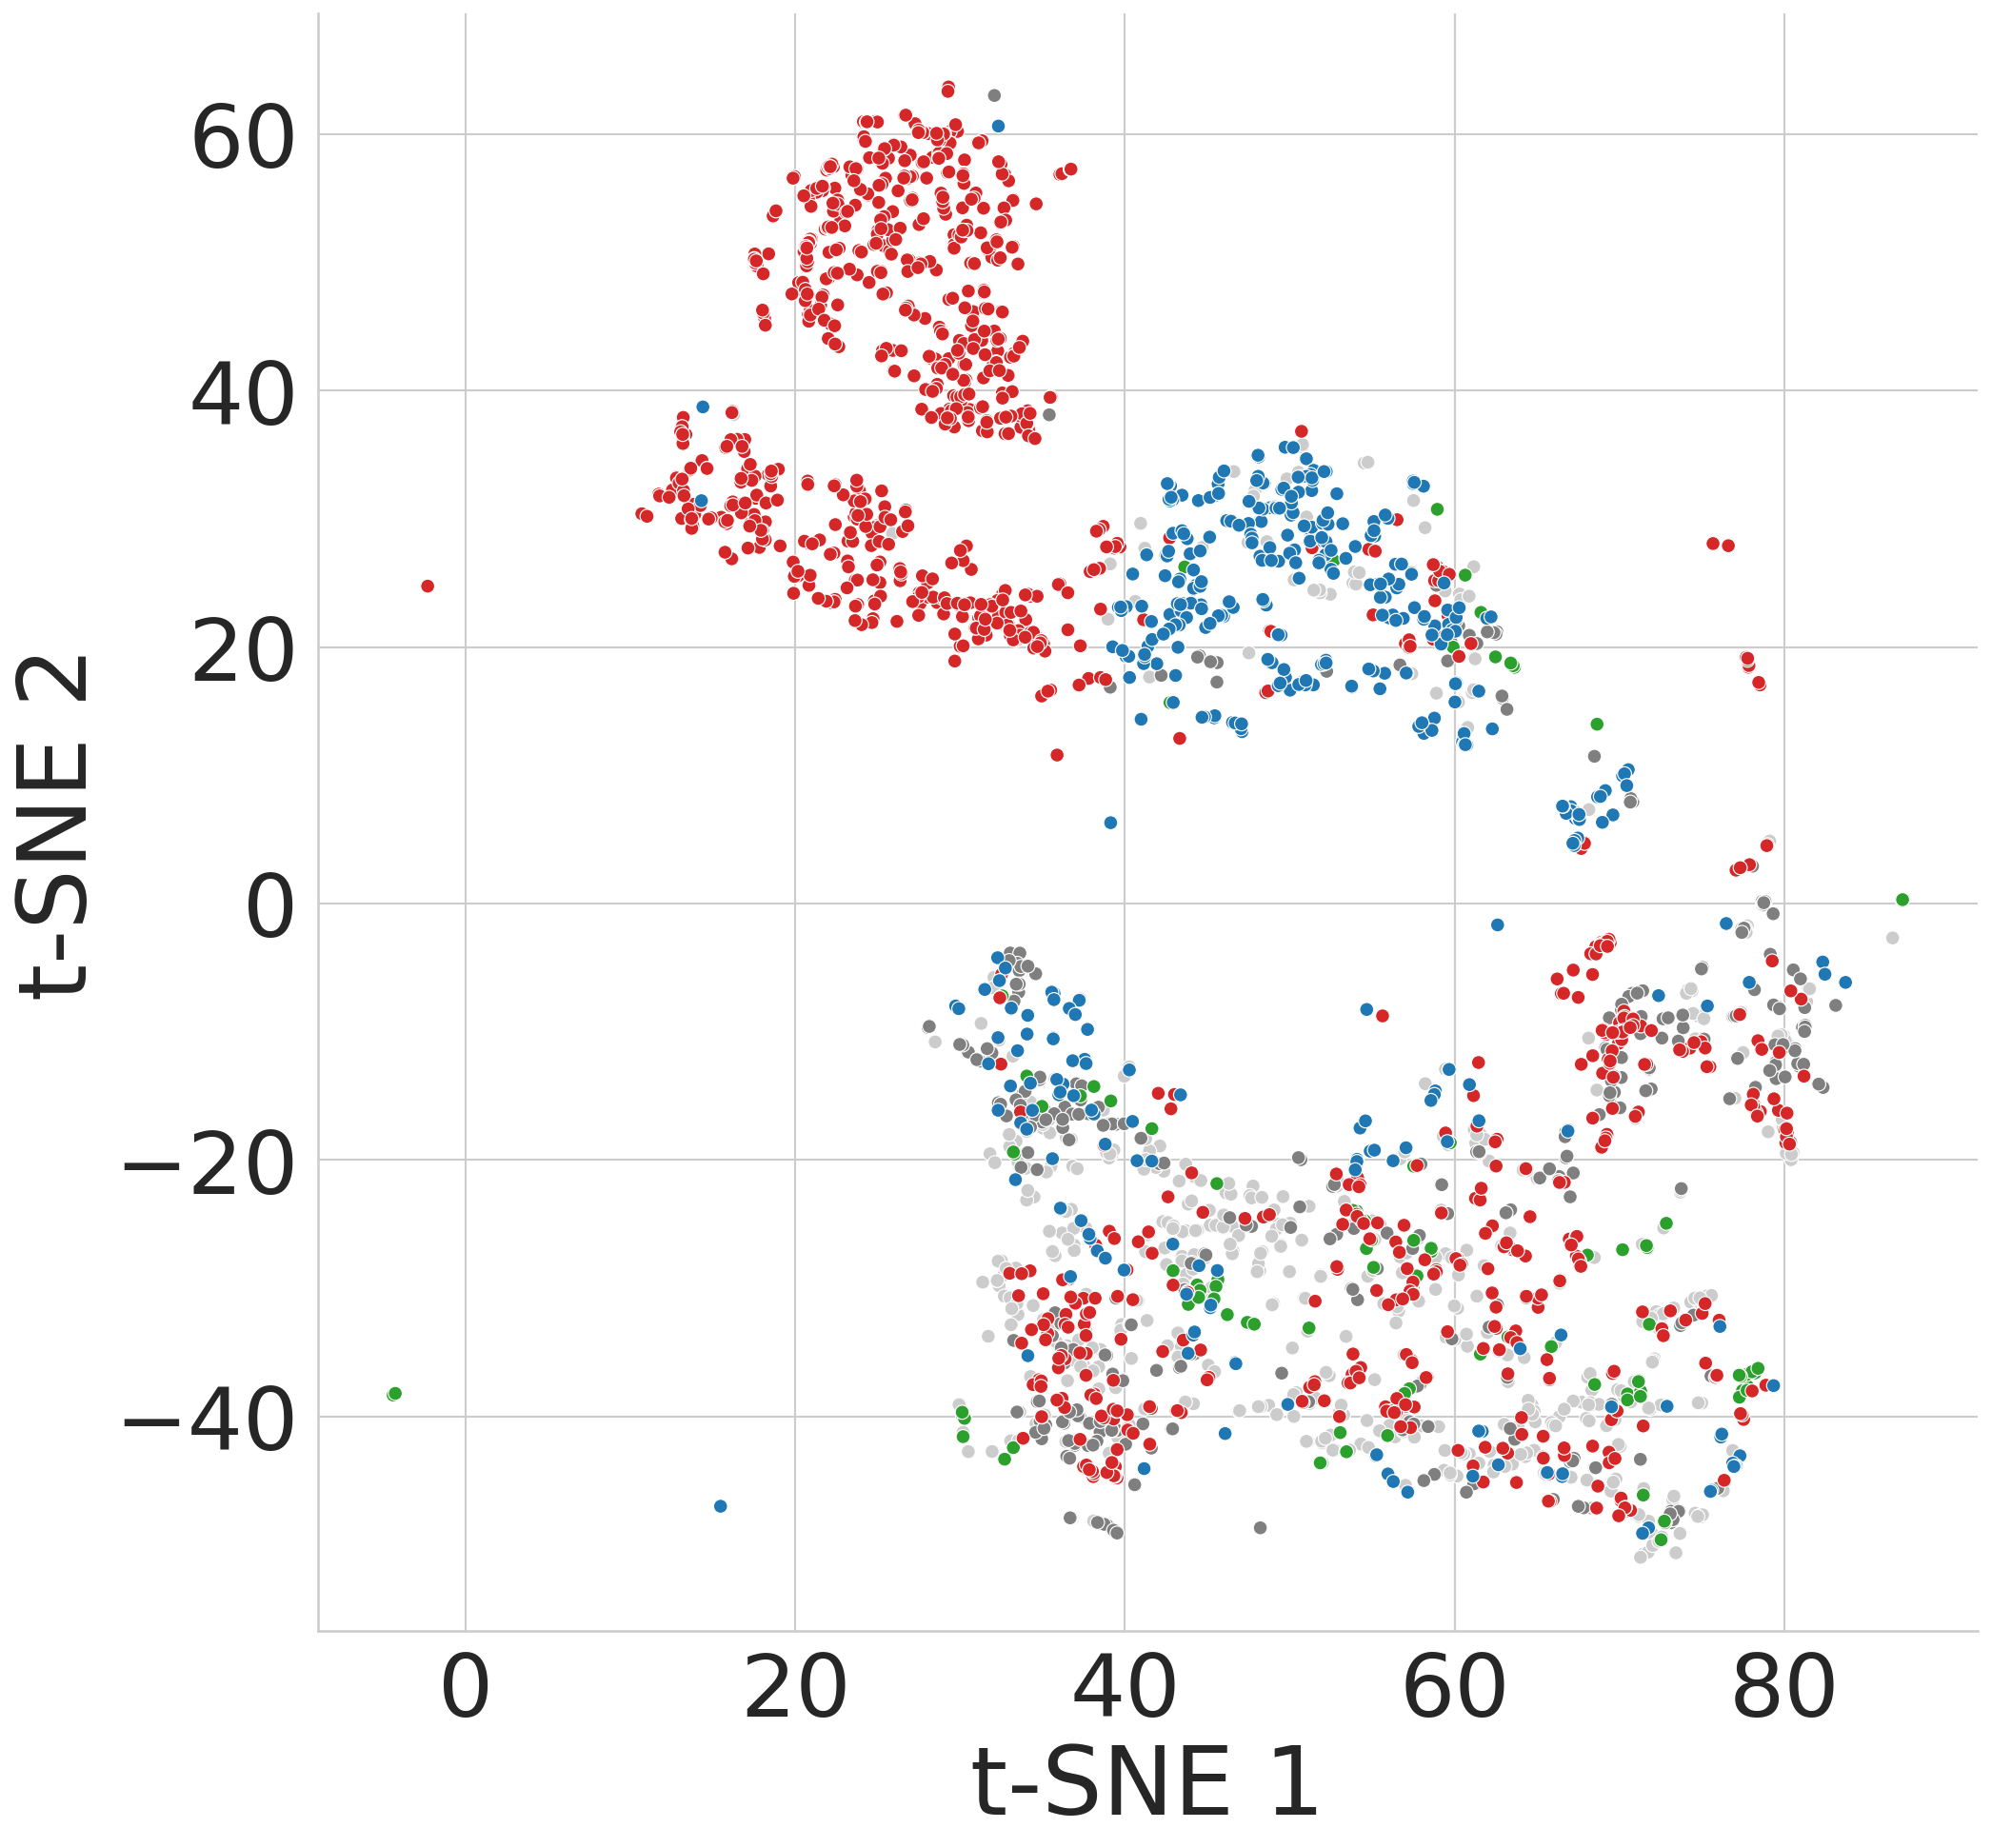

In [64]:
sns.set(style='whitegrid',font_scale=4)
plt.figure(figsize=(15, 15), dpi=150)

style = ['Protein'] * prot_projections.shape[0]# + ['Molecule'] * mol_projections.shape[0]
# style = ['Molecule'] * mol_projections.shape[0]

surfaceome_df = pd.DataFrame({
    't-SNE 1': embed_tsne[:n_prots,0],
    't-SNE 2': embed_tsne[:n_prots,1],
    'Almen Class': almen_class
})
surfaceome_df = surfaceome_df.fillna('Unclassified')
surfaceome_df['Almen Class'] = pd.Categorical(surfaceome_df['Almen Class'], ['Transporters','Receptors','Enzymes','Miscellaneous','Unclassified'])
surfaceome_df = surfaceome_df.sort_values(by='Almen Class',ascending=False)

sns.scatterplot(
    data = surfaceome_df,
    x = "t-SNE 1",
    y = "t-SNE 2",
    hue = 'Almen Class',
    s=50,
    alpha=1,
    palette=palette,
    hue_order=['Transporters','Receptors','Enzymes','Miscellaneous','Unclassified'],
    legend=False
   )
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
# plt.title('Projection of Surfaceome Proteins into DTI Space')
sns.despine()
plt.savefig('../img/surfaceome/surfaceome_almen_class_tsne.png',bbox_inches='tight')
plt.show()

In [72]:
# sns.set(style='whitegrid',font_scale=1.5)
# plt.figure(figsize=(15, 15), dpi=150)

# style = ['Protein'] * prot_projections.shape[0]# + ['Molecule'] * mol_projections.shape[0]
# # style = ['Molecule'] * mol_projections.shape[0]

# surfaceome_df = pd.DataFrame({
#     't-SNE 1': protbert_tsne[:n_prots,0],
#     't-SNE 2': protbert_tsne[:n_prots,1],
#     'Almen Class': almen_class
# })

# sns.scatterplot(
#     data = surfaceome_df,
#     x = "t-SNE 1",
#     y = "t-SNE 2",
#     hue = 'Almen Class',
#     s=25,
#     alpha=1,
#     palette=palette,
#    )
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.title('ProtBert Embeddings')
# sns.despine()
# # plt.savefig('../img/surfaceome_almen_class_tsne.png',bbox_inches='tight')
# plt.show()

## Domains

In [73]:
dom_name_key = domtbl[['DomAccession','DomName']].drop_duplicates()

In [74]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

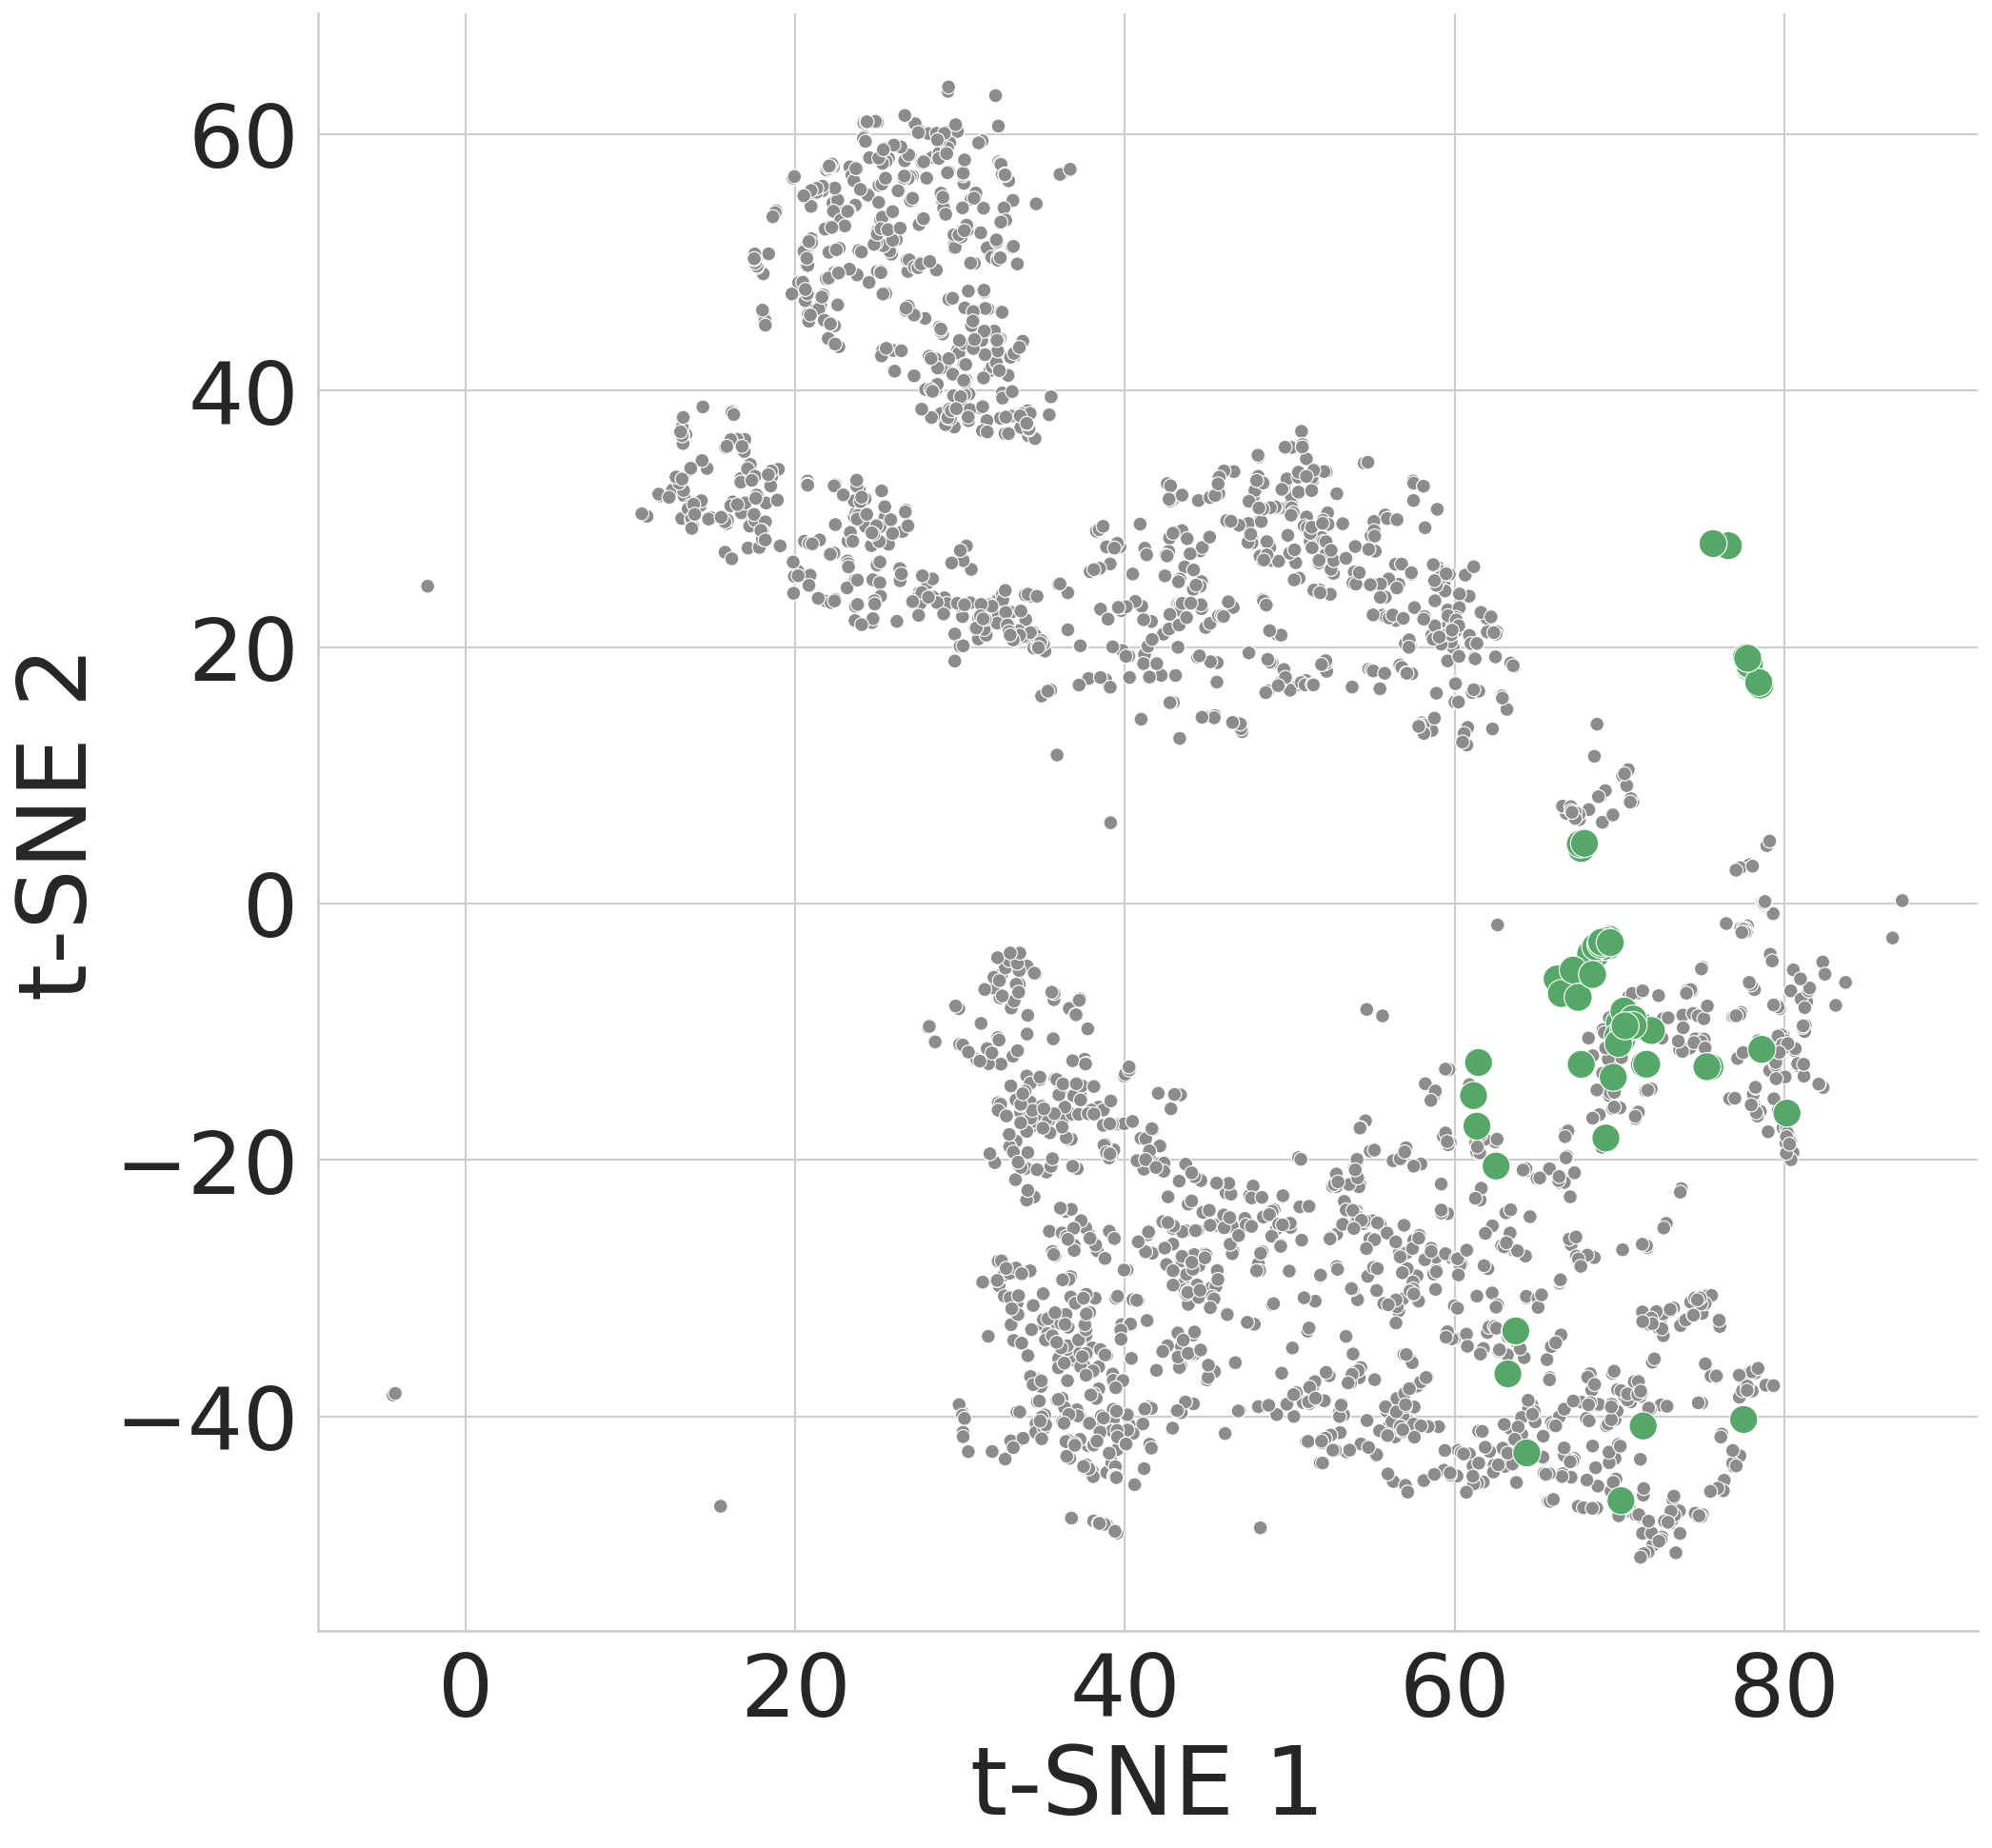

In [68]:
sns.set(style='whitegrid',font_scale=4)
plt.figure(figsize=(15, 15), dpi=150)

pal = [sns.color_palette()[i] for i in [7,2]]

# ind = 0
# domain = domsrted.index[ind]
# domain = 'PF07714.18'
# domain = 'PF10323.10'
# domain = 'PF00069.26'
domain = 'PF00069.26'

plot_dom_df = pd.DataFrame({
    't-SNE 1': embed_tsne[:prot_projections.shape[0],0],
    't-SNE 2': embed_tsne[:prot_projections.shape[0],1],
    f'Has {domain} Domain?': get_pfd_code(domain),
    'Size': [200 if i=='yes' else 50 for i in get_pfd_code(domain)]
})

ax = sns.scatterplot(
    data = plot_dom_df.sort_values(by=f'Has {domain} Domain?'),
    x = 't-SNE 1',
    y = 't-SNE 2',
    hue = f'Has {domain} Domain?',
    s=plot_dom_df.sort_values(by=f'Has {domain} Domain?')['Size'],
    alpha=1,
    palette = pal,
)
ax.get_legend().set_visible(False)
# plt.title(f'Surfaceome proteins contain {dom_name_key[dom_name_key["DomAccession"] == domain].DomName.item()}')
sns.despine()
plt.savefig(f'../img/surfaceome/surfaceome_pfam{domain}_scatter.png',bbox_inches='tight')
plt.show()

In [69]:
n_domains = len(domsrted[domsrted > 10])
print(n_domains)

126


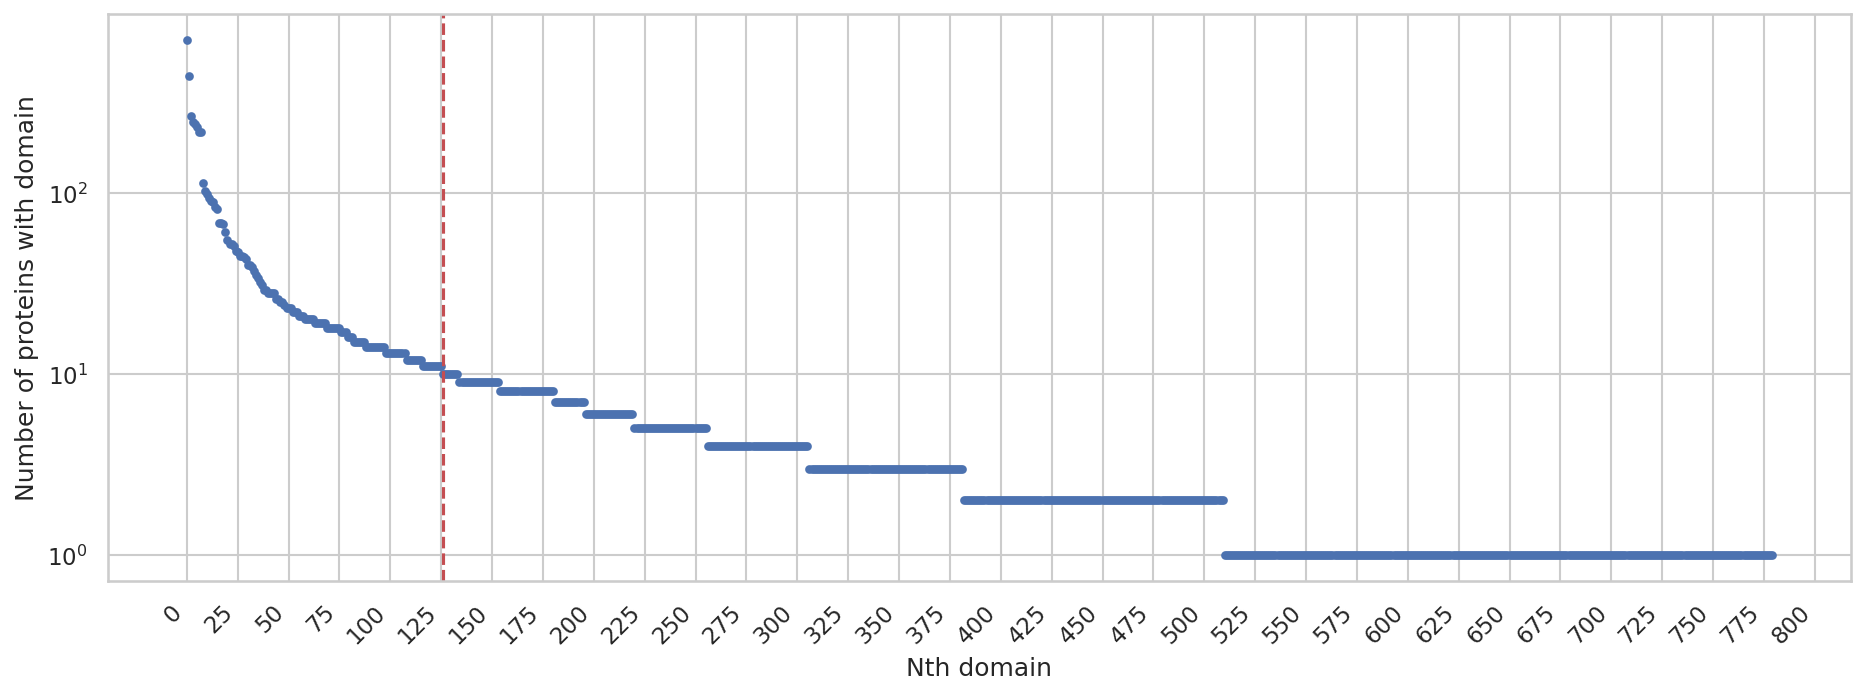

In [70]:
plt.figure(figsize=(15, 5), dpi=150)
sns.set(font_scale=1,style='whitegrid')
plt.scatter(np.arange(len(domsrted)), domsrted,s=10)
plt.xticks(np.arange(0,825,25),ha='right',rotation=45)
plt.xlabel('Nth domain')
plt.ylabel('Number of proteins with domain')
plt.axvline(n_domains,c='r',linestyle='--')
plt.yscale('log')
plt.savefig(f'../img/surfaceome/domain_size_distribution.svg',bbox_inches='tight')
# plt.savefig(f'../img/surfaceome/domain_size_distribution.png',bbox_inches='tight')
plt.show()

0.24972902


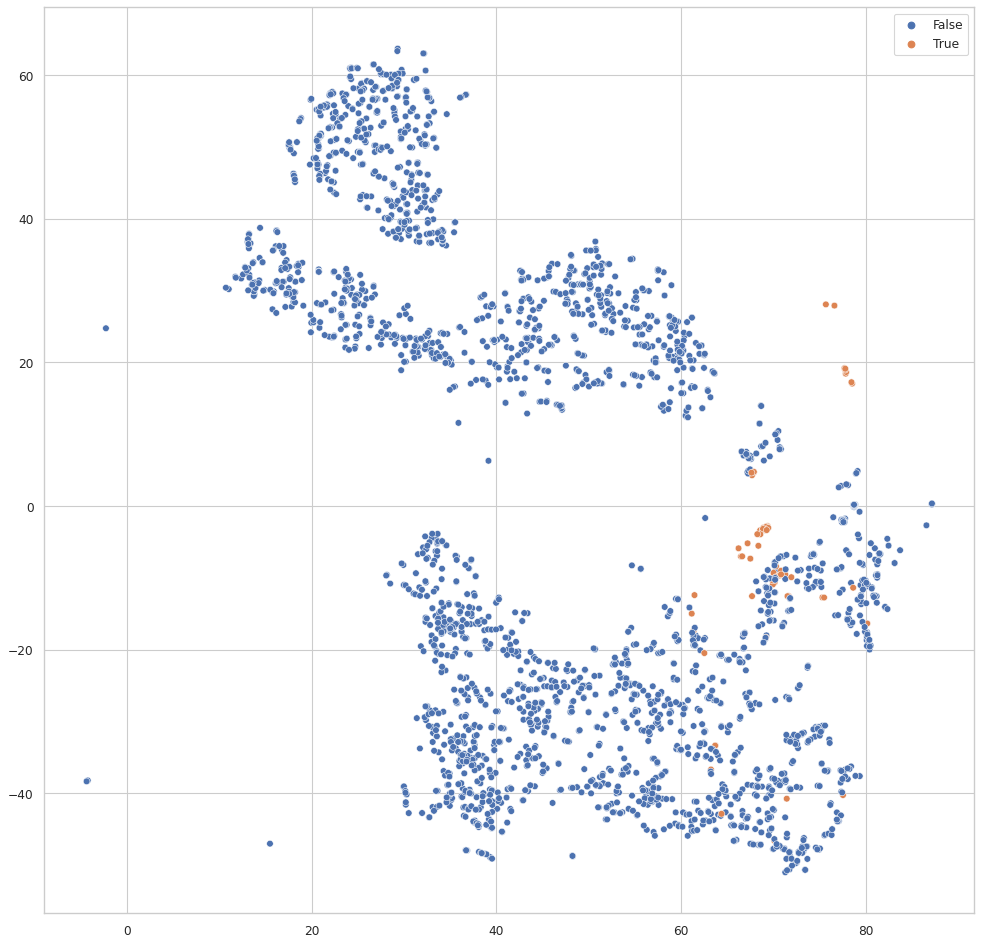

In [71]:
## We do well
# domn = 'PF00069.26'
# domn = 'PF07714.18'
# domn = 'PF01404.20'
domn = 'PF00069.26'

## We do poorly
# domn = 'PF16492.6'
# domn = 'PF15974.6'

labels_a = [a=='yes' for a in get_pfd_code(domn)]
ssa = silhouette_score(prot_projections, labels_a, metric='cosine')
print(ssa)

plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(
    x=embed_tsne[:prot_projections.shape[0],0],
    y=embed_tsne[:prot_projections.shape[0],1],
    hue=labels_a,
)
plt.show()

## Logistic Classifier (fully supervised)

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import average_precision_score, accuracy_score, matthews_corrcoef, f1_score

logistic_results = []

pal = [sns.color_palette("colorblind")[i] for i in [7,1]]

for domn in tqdm(domsrted.index[:n_domains]):
    
    labels = [int(a=='yes') for a in get_pfd_code(domn)]
    
    conplex_lrm = LogisticRegression(class_weight='balanced')
    protbert_lrm = LogisticRegression(class_weight='balanced')
    
    cp_feats_norm = normalize(prot_projections,axis=1,norm='l2')
    pb_feats_norm = normalize(protbert_np,axis=1,norm='l2')
    
    conplex_lrm.fit(cp_feats_norm, labels)
    protbert_lrm.fit(pb_feats_norm, labels)
    
    conplex_pred_clust = conplex_lrm.predict(cp_feats_norm)
    protbert_pred_clust = protbert_lrm.predict(pb_feats_norm)
    
    cp_mcc = matthews_corrcoef(labels, conplex_pred_clust)
    pb_mcc = matthews_corrcoef(labels, protbert_pred_clust)
    
    cp_f1 = f1_score(labels, conplex_pred_clust)
    pb_f1 = f1_score(labels, protbert_pred_clust)
    
    cp_aupr = average_precision_score(labels, conplex_pred_clust)
    pb_aupr = average_precision_score(labels, protbert_pred_clust)
    
    cp_mean_proba = np.array([np.log(i[1]/i[0]) for (i,l) in zip(conplex_lrm.predict_proba(cp_feats_norm), labels) if l]).mean()
    pb_mean_proba = np.array([np.log(i[1]/i[0]) for (i,l) in zip(protbert_lrm.predict_proba(pb_feats_norm), labels) if l]).mean()
    
    logistic_results.append((domn, sum(labels), cp_mean_proba, pb_mean_proba, cp_mcc, pb_mcc, cp_f1, pb_f1, cp_aupr, pb_aupr))
logistic_results = pd.DataFrame(logistic_results,columns=['Domain','Size','CP Mean log(P)', 'PB Mean log(P)', 'CP MCC','PB MCC','CP F1', 'PB F1', 'CP AUPR', 'PB AUPR'])

  0%|          | 0/126 [00:00<?, ?it/s]

In [76]:
logistic_results['Residual'] = logistic_results['CP Mean log(P)'] - logistic_results['PB Mean log(P)']
logistic_results_sorted = pd.merge(logistic_results.sort_values(by='Residual', ascending=False), dom_name_key, left_on='Domain', right_on='DomAccession')

In [77]:
tstat, tp = ttest_rel(logistic_results['CP Mean log(P)'],logistic_results['PB Mean log(P)'],alternative='greater')

In [78]:
logistic_results_sorted.tail(30)

,Domain,Size,CP Mean log(P),PB Mean log(P),CP MCC,PB MCC,CP F1,PB F1,CP AUPR,PB AUPR,Residual,DomAccession,DomName
96,PF13520.7,15,2.778409,2.268496,0.391431,0.393582,0.272727,0.275229,0.157895,0.159574,0.509913,PF13520.7,AA_permease_2
97,PF00129.19,20,3.031551,2.522947,0.442832,0.429501,0.336134,0.320000,0.202020,0.190476,0.508604,PF00129.19,MHC_I
98,PF10324.10,12,2.358728,1.854473,0.250796,0.260264,0.125654,0.134078,0.067039,0.071856,0.504256,PF10324.10,7TM_GPCR_Srw
99,PF10328.10,84,1.697254,1.212823,0.390528,0.361408,0.303249,0.281690,0.178723,0.158891,0.484431,PF10328.10,7TM_GPCR_Srx
100,PF00474.18,12,2.828591,2.350651,0.422122,0.476818,0.307692,0.375000,0.181818,0.230769,0.477940,PF00474.18,SSF
101,PF01462.19,13,2.156987,1.684990,0.303233,0.383511,0.175676,0.262626,0.096296,0.151163,0.471997,PF01462.19,LRRNT
102,PF01049.18,24,2.951517,2.484899,0.424566,0.480445,0.315789,0.384000,0.187500,0.237624,0.466618,PF01049.18,Cadherin_C
103,PF16681.6,51,2.294996,1.856696,0.409667,0.402340,0.310030,0.305810,0.183453,0.177975,0.438300,PF16681.6,Ig_5
104,PF13903.7,29,2.518918,2.089879,0.418010,0.442308,0.310160,0.339181,0.183544,0.204225,0.429039,PF13903.7,Claudin_2
105,PF00822.21,34,2.467149,2.042584,0.456108,0.467992,0.357895,0.379310,0.217949,0.229150,0.424565,PF00822.21,PMP22_Claudin


In [79]:
pal_map = {
    f'Cadherin': sns.color_palette()[0],
    f'7TM': sns.color_palette()[1],
    f'Kinase': sns.color_palette()[2],
    f'Immunoglobulin': sns.color_palette()[3],
    f'Other': 'lightgray',
}

In [80]:
def assign(d):
    if 'Cadherin' in d:
        return 'Cadherin'
    elif '7tm' in d or '7TM' in d or 'GPCR' in d:
        return '7TM'
    elif 'PK_Tyr' in d or 'Pkinase' in d or 'Eph' in d:
        return 'Kinase'
    elif 'ig' in d or 'Ig' in d or 'IG' in d:
        return 'Immunoglobulin'
    else:
        return 'Other'

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


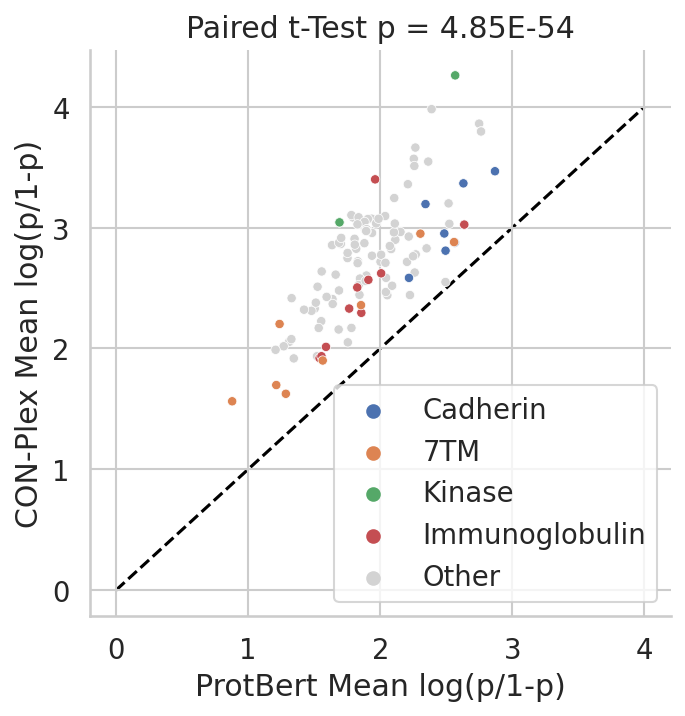

In [81]:
logistic_results_sorted['Annot'] = [assign(d) for d in logistic_results_sorted['DomName']]
df_to_plot = logistic_results_sorted.sort_values(by='Annot', ascending=False)

plt.figure(figsize=(5, 5), dpi=150)
sns.set(font_scale=1.2,style='whitegrid')
sns.scatterplot(data=df_to_plot,
                x='PB Mean log(P)',
                y='CP Mean log(P)',
                hue=df_to_plot['Annot'],
                palette=pal_map,
                # hue_order=['Other', 'Cadherin', '7TM'],
                hue_order=['Cadherin', '7TM', 'Kinase', 'Immunoglobulin', 'Other'],
                s=20,
               )

# for i, r in logistic_results_sorted.sort_values(by='Annot',ascending=False).reset_index().iterrows():
#     xef = r['PB Mean log(P)']
#     yef = r['CP Mean log(P)']
#     if 'Cadherin' in r['DomName']:
#         plt.annotate(r['DomName'].upper(),
#                      (xef, yef),
#                      # color = pal_map[target_type_hue[i]],
#                      fontsize='small',
#                      # backgroundcolor='white'
#                     )

plt.plot([0, 4],[0,4],linestyle='--',c='black',zorder=0)
sns.despine()
plt.title(f'Paired t-Test p = {tp:.2E}')
plt.legend(loc='lower right')
plt.xlabel('ProtBert Mean log(p/1-p)')
plt.ylabel('CON-Plex Mean log(p/1-p)')
plt.savefig(f'../img/surfaceome/logistic_classification_compareScatter.svg',bbox_inches='tight')
plt.show()

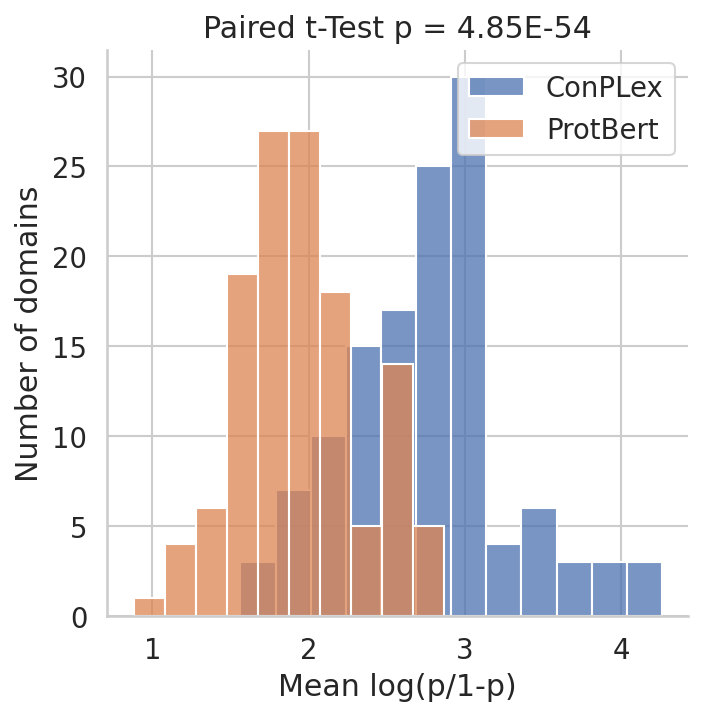

In [82]:
plt.figure(figsize=(5, 5), dpi=150)
sns.set(font_scale=1.2,style='whitegrid')
sns.histplot(logistic_results['CP Mean log(P)'],color=sns.color_palette()[0],label='ConPLex')
sns.histplot(logistic_results['PB Mean log(P)'],color=sns.color_palette()[1],label='ProtBert')
# plt.axvline(0,linestyle='--',linewidth=5,c='black')
plt.xlabel('Mean log(p/1-p)')
plt.ylabel('Number of domains')
plt.title(f'Paired t-Test p = {tp:.2E}')
plt.legend()
sns.despine()
plt.savefig(f'../img/surfaceome/logistic_classification_compareHistogram.svg',bbox_inches='tight')
plt.show()

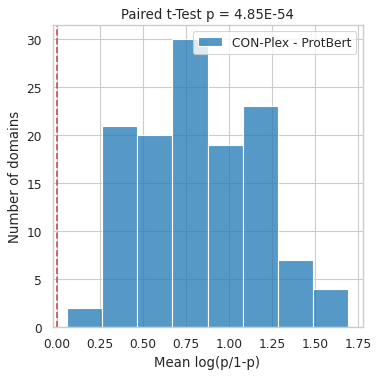

In [83]:
tstat, tp = ttest_rel(logistic_results['CP Mean log(P)'],logistic_results['PB Mean log(P)'],alternative='greater')
plt.figure(figsize=(5, 5), dpi=80)
sns.set(font_scale=1,style='whitegrid')
sns.histplot(logistic_results['Residual'],color=sns.color_palette('tab10')[0],label='CON-Plex - ProtBert')
plt.axvline(0,c='r',linestyle='--')
plt.xlabel('Mean log(p/1-p)')
plt.ylabel('Number of domains')
plt.title(f'Paired t-Test p = {tp:.2E}')
plt.legend()
plt.show()

In [84]:
logistic_results_sorted[logistic_results_sorted['Annot'].str.contains('7TM')]

,Domain,Size,CP Mean log(P),PB Mean log(P),CP MCC,PB MCC,CP F1,PB F1,CP AUPR,PB AUPR,Residual,DomAccession,DomName,Annot
47,PF00003.23,22,2.202610,1.237913,0.379143,0.393598,0.261905,0.278481,0.150685,0.161765,0.964697,PF00003.23,7tm_3,7TM
79,PF00002.25,52,1.562838,0.879004,0.404093,0.436872,0.304094,0.342105,0.179310,0.206349,0.683834,PF00002.25,7tm_2,7TM
86,PF00001.22,699,2.950090,2.303791,0.938921,0.939284,0.954420,0.954993,0.914950,0.919635,0.646299,PF00001.22,7tm_1,7TM
98,PF10324.10,12,2.358728,1.854473,0.250796,0.260264,0.125654,0.134078,0.067039,0.071856,0.504256,PF10324.10,7TM_GPCR_Srw,7TM
99,PF10328.10,84,1.697254,1.212823,0.390528,0.361408,0.303249,0.281690,0.178723,0.158891,0.484431,PF10328.10,7TM_GPCR_Srx,7TM
118,PF10320.10,239,1.624874,1.285315,0.522800,0.531287,0.507527,0.517621,0.338352,0.346864,0.339559,PF10320.10,7TM_GPCR_Srsx,7TM
119,PF10323.10,40,1.900395,1.564513,0.317878,0.329787,0.205128,0.221591,0.114286,0.122243,0.335882,PF10323.10,7TM_GPCR_Srv,7TM
120,PF13853.7,445,2.880605,2.558824,0.875989,0.925849,0.894901,0.938053,0.810766,0.887887,0.321782,PF13853.7,7tm_4,7TM


In [85]:
logistic_results_sorted[logistic_results_sorted['Annot'].str.contains('Cadherin')]

,Domain,Size,CP Mean log(P),PB Mean log(P),CP MCC,PB MCC,CP F1,PB F1,CP AUPR,PB AUPR,Residual,DomAccession,DomName,Annot
55,PF08758.12,14,3.194878,2.342453,0.470951,0.366266,0.368421,0.243478,0.225806,0.138614,0.852425,PF08758.12,Cadherin_pro,Cadherin
72,PF16492.6,40,3.366480,2.629435,0.652943,0.735655,0.606061,0.707965,0.434783,0.547945,0.737045,PF16492.6,Cadherin_C_2,Cadherin
90,PF15974.6,37,3.466634,2.868428,0.657836,0.702207,0.611570,0.666667,0.440476,0.500000,0.598206,PF15974.6,Cadherin_tail,Cadherin
102,PF01049.18,24,2.951517,2.484899,0.424566,0.480445,0.315789,0.384000,0.187500,0.237624,0.466618,PF01049.18,Cadherin_C,Cadherin
117,PF16184.6,67,2.584103,2.217382,0.559557,0.687147,0.496296,0.656716,0.330049,0.485554,0.366722,PF16184.6,Cadherin_3,Cadherin
121,PF00028.18,114,2.809350,2.494246,0.661776,0.881250,0.631579,0.881890,0.461538,0.786701,0.315104,PF00028.18,Cadherin,Cadherin
122,PF08266.13,89,2.876398,2.564311,0.658182,0.824268,0.622378,0.816514,0.451777,0.689922,0.312087,PF08266.13,Cadherin_2,Cadherin


In [86]:
logistic_results_sorted[logistic_results_sorted['Annot'].str.contains('Kinase')]

,Domain,Size,CP Mean log(P),PB Mean log(P),CP MCC,PB MCC,CP F1,PB F1,CP AUPR,PB AUPR,Residual,DomAccession,DomName,Annot
0,PF14575.7,14,4.260073,2.567286,0.762348,0.445835,0.736842,0.337349,0.583333,0.202899,1.692787,PF14575.7,EphA2_TM,Kinase
1,PF01404.20,14,4.260073,2.567286,0.762348,0.445835,0.736842,0.337349,0.583333,0.202899,1.692787,PF01404.20,Ephrin_lbd,Kinase
6,PF00069.26,68,3.043665,1.691549,0.590266,0.532666,0.538153,0.474453,0.365090,0.302718,1.352116,PF00069.26,Pkinase,Kinase
7,PF07714.18,68,3.043665,1.691549,0.590266,0.532666,0.538153,0.474453,0.365090,0.302718,1.352116,PF07714.18,PK_Tyr_Ser-Thr,Kinase


In [87]:
cadherin_table = logistic_results_sorted[logistic_results_sorted['Annot'].str.contains('Kinase') | logistic_results_sorted['Annot'].str.contains('Cadherin')]
cadherin_table = cadherin_table.sort_values('Annot')
cadherin_table = cadherin_table.set_index('DomName')
cadherin_table.index.name = 'Domain'
cadherin_table = cadherin_table[['CP Mean log(P)', 'PB Mean log(P)']]
cadherin_table.columns = ['CON-Plex','ProtBert']

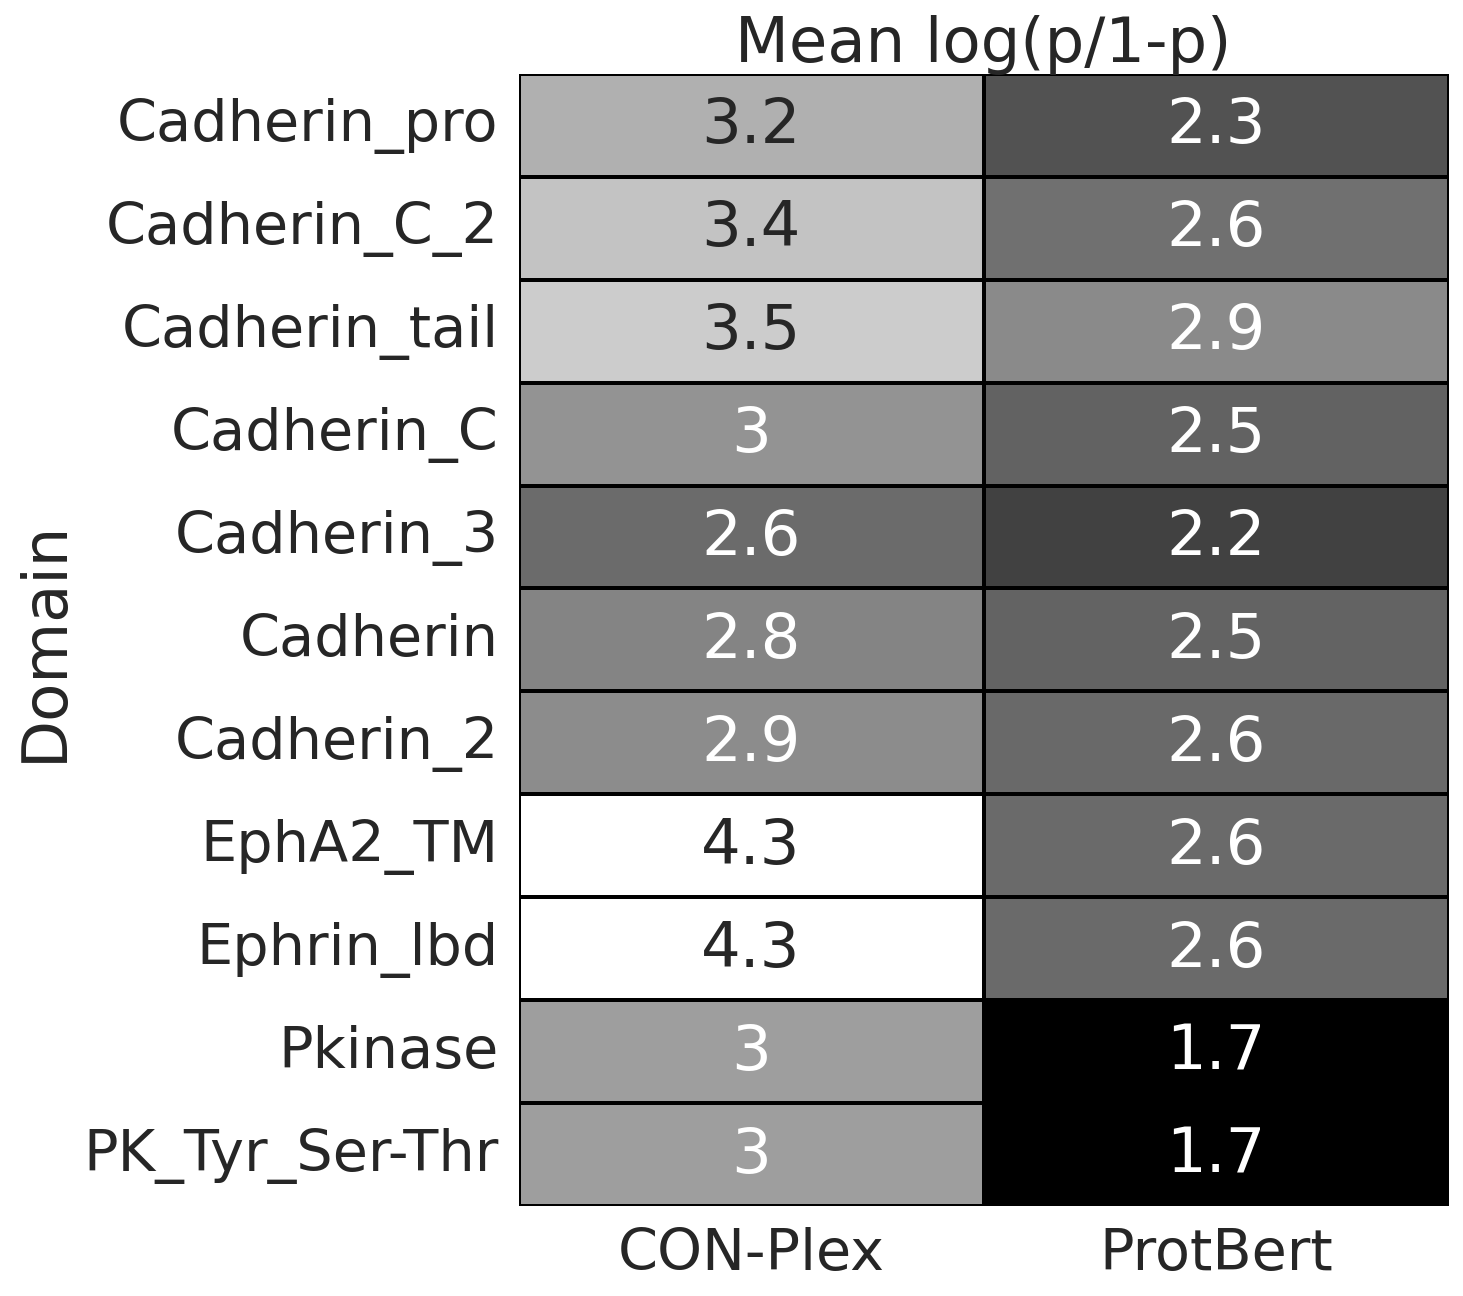

In [88]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(8, 10), dpi=150)
sns.set(font_scale=2.5,style='whitegrid')
sns.heatmap(
    data=cadherin_table[['CON-Plex','ProtBert']],
    annot=True,
    xticklabels=True, yticklabels=True,
    linewidths=1, linecolor='black',
    cmap='Greys_r',cbar=False
)
plt.title('Mean log(p/1-p)')
plt.savefig(f'../img/surfaceome/cadherin_kinase_score_table.svg',bbox_inches='tight')

In [90]:
logistic_results_sorted.head(25)

,Domain,Size,CP Mean log(P),PB Mean log(P),CP MCC,PB MCC,CP F1,PB F1,CP AUPR,PB AUPR,Residual,DomAccession,DomName,Annot
0,PF14575.7,14,4.260073,2.567286,0.762348,0.445835,0.736842,0.337349,0.583333,0.202899,1.692787,PF14575.7,EphA2_TM,Kinase
1,PF01404.20,14,4.260073,2.567286,0.762348,0.445835,0.736842,0.337349,0.583333,0.202899,1.692787,PF01404.20,Ephrin_lbd,Kinase
2,PF00536.31,14,4.260073,2.567286,0.762348,0.445835,0.736842,0.337349,0.583333,0.202899,1.692787,PF00536.31,SAM_1,Other
3,PF07647.18,15,3.980228,2.388650,0.580731,0.387227,0.508475,0.267857,0.340909,0.154639,1.591578,PF07647.18,SAM_2,Other
4,PF01833.25,13,3.399443,1.961264,0.349301,0.236530,0.224138,0.114035,0.126214,0.060465,1.438179,PF01833.25,TIG,Immunoglobulin
5,PF08441.13,18,3.662626,2.265850,0.714874,0.668080,0.679245,0.620690,0.514286,0.450000,1.396777,PF08441.13,Integrin_alpha2,Other
6,PF00069.26,68,3.043665,1.691549,0.590266,0.532666,0.538153,0.474453,0.365090,0.302718,1.352116,PF00069.26,Pkinase,Kinase
7,PF07714.18,68,3.043665,1.691549,0.590266,0.532666,0.538153,0.474453,0.365090,0.302718,1.352116,PF07714.18,PK_Tyr_Ser-Thr,Kinase
8,PF00089.27,12,3.103725,1.781428,0.384883,0.332197,0.263736,0.205128,0.151899,0.114286,1.322298,PF00089.27,Trypsin,Other
9,PF01839.24,19,3.569682,2.253911,0.677963,0.695390,0.633333,0.655172,0.463415,0.487179,1.315771,PF01839.24,FG-GAP,Other


In [91]:
logistic_results_sorted.tail(15)

,Domain,Size,CP Mean log(P),PB Mean log(P),CP MCC,PB MCC,CP F1,PB F1,CP AUPR,PB AUPR,Residual,DomAccession,DomName,Annot
111,PF00497.21,18,3.025128,2.636047,0.443762,0.772872,0.336449,0.750000,0.202247,0.600000,0.389081,PF00497.21,SBP_bac_3,Other
112,PF08205.13,99,2.170090,1.781968,0.516085,0.520585,0.455814,0.461176,0.293450,0.297945,0.388122,PF08205.13,C2-set_2,Other
113,PF01094.29,35,2.440597,2.053505,0.392676,0.556130,0.283401,0.482759,0.165094,0.318182,0.387092,PF01094.29,ANF_receptor,Other
114,PF13927.7,247,1.935708,1.555153,0.652476,0.652444,0.656467,0.654746,0.481783,0.481080,0.380556,PF13927.7,Ig_3,Immunoglobulin
115,PF00047.26,265,1.920131,1.540633,0.664649,0.667884,0.672872,0.675532,0.500401,0.503961,0.379499,PF00047.26,ig,Immunoglobulin
116,PF01490.19,13,2.628350,2.260647,0.393052,0.383511,0.273684,0.262626,0.158537,0.151163,0.367703,PF01490.19,Aa_trans,Other
117,PF16184.6,67,2.584103,2.217382,0.559557,0.687147,0.496296,0.656716,0.330049,0.485554,0.366722,PF16184.6,Cadherin_3,Cadherin
118,PF10320.10,239,1.624874,1.285315,0.522800,0.531287,0.507527,0.517621,0.338352,0.346864,0.339559,PF10320.10,7TM_GPCR_Srsx,7TM
119,PF10323.10,40,1.900395,1.564513,0.317878,0.329787,0.205128,0.221591,0.114286,0.122243,0.335882,PF10323.10,7TM_GPCR_Srv,7TM
120,PF13853.7,445,2.880605,2.558824,0.875989,0.925849,0.894901,0.938053,0.810766,0.887887,0.321782,PF13853.7,7tm_4,7TM


In [92]:
logistic_results_sorted['DomName'].values

array(['EphA2_TM', 'Ephrin_lbd', 'SAM_1', 'SAM_2', 'TIG',
       'Integrin_alpha2', 'Pkinase', 'PK_Tyr_Ser-Thr', 'Trypsin',
       'FG-GAP', 'Sema', 'VCBS', 'PKD_channel', 'Zona_pellucida', 'VWA_2',
       'TSP_1', 'VWA', 'ABC_membrane', 'ADAM_CR', 'Frizzled',
       'F5_F8_type_C', 'Ldl_recept_b', 'UPAR_LY6', 'Tissue_fac',
       'E1-E2_ATPase', 'Hydrolase', 'FXa_inhibition', 'NCD3G',
       'Reprolysin', 'Pep_M12B_propep', 'Disintegrin', 'CUB',
       'Reprolysin_4', 'PSI', 'Reprolysin_5', 'Reprolysin_3',
       'Reprolysin_2', 'IL6Ra-bind', 'EGF_2', 'Ion_trans', 'GP41',
       'HERV-K_env_2', 'Neur_chan_memb', 'Laminin_EGF', 'TNFR_c6',
       'Neur_chan_LBD', 'Fz', '7tm_3', 'PA', 'TIR', 'GAIN', 'Kazal_2',
       'AAA_21', 'MAM', 'ABC2_membrane_3', 'Cadherin_pro', 'Laminin_G_1',
       'Laminin_G_2', 'Laminin_G_3', 'ABC_tran', 'cEGF', 'TIR_2',
       'Interfer-bind', 'RET_CLD1', 'GPS', 'Sugar_tr', 'Y_phosphatase',
       'LRR_9', 'Sushi', 'Ldl_recept_a', 'HRM', 'LRR_5', 'Cadherin_C_2

# PKinase and PK_Tyr_Ser-Thr Explainability Mutagenesis

In [94]:
domain = "PF00069.26"
# domain = "PF07714.18"
# domain = "PF14575.7"
# domain = "PF01404.20"

In [96]:
spec_dom_db = full_dom_db[full_dom_db['DomAccession'].str.contains(domain)]

In [101]:
spec_dom_db.head()

,UniProt name,UniProt description,UniProt gene,Surfaceome Label,Surfaceome Label Source,Comment,length,TM domains,signalpeptide,topology,...,Organism,Length,Sequence,EC number,Cross-reference (Pfam),Cross-reference (BindingDB),Cross-reference (DrugBank),Query,DomName,DomAccession
UniProt accession,,,,,,,,,,,,,,,,,,,,,
O15146,MUSK_HUMAN,"Muscle, skeletal receptor tyrosine-protein kinase",MUSK,surface,machine learning,NaN,869,1,1,SP:1-19;NC:20-492;TM:493-518;CY:519-869,...,Homo sapiens (Human),869.0,MRELVNIPLVHILTLVAFSGTEKLPKAPVITTPLETVDALVEEVAT...,2.7.10.1,PF01392;PF07679;PF07714;,O15146;,DB12010;,O15146,"PK_Tyr_Ser-Thr,I-set,Ig_3,Pkinase,Ig_2,ig,Fz,C...","PF07714.18,PF07679.17,PF13927.7,PF00069.26,PF1..."
O15197,EPHB6_HUMAN,Ephrin type-B receptor 6,EPHB6,surface,machine learning,NaN,1021,1,1,SP:1-31;NC:32-594;TM:595-619;CY:620-1021,...,Homo sapiens (Human),1021.0,MATEGAAQLGNRVAGMVCSLWVLLLVSSVLALEEVLLDTTGETSEI...,NaN,PF14575;PF01404;PF07699;PF00041;PF07714;PF07647;,O15197;,DB12010;,O15197,"PK_Tyr_Ser-Thr,Ephrin_lbd,Pkinase,fn3,SAM_2,Ep...","PF07714.18,PF01404.20,PF00069.26,PF00041.22,PF..."
P00533,EGFR_HUMAN,Epidermal growth factor receptor,EGFR,surface,pos. trainingset,NaN,1210,1,1,SP:1-24;NC:25-645;TM:646-668;CY:669-1210,...,Homo sapiens (Human),1210.0,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,2.7.10.1,PF00757;PF14843;PF07714;PF01030;,P00533;,DB15327;DB08916;DB03496;DB16695;DB06021;DB1226...,P00533,"PK_Tyr_Ser-Thr,Recep_L_domain,GF_recep_IV,Pkin...","PF07714.18,PF01030.25,PF14843.7,PF00069.26,PF0..."
P04626,ERBB2_HUMAN,Receptor tyrosine-protein kinase erbB-2,ERBB2,surface,pos. trainingset,NaN,1255,1,1,SP:1-22;NC:23-652;TM:653-675;CY:676-1255,...,Homo sapiens (Human),1255.0,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,2.7.10.1,PF00757;PF14843;PF07714;PF01030;,P04626;,DB08916;DB06021;DB12267;DB12010;DB04988;DB0125...,P04626,"PK_Tyr_Ser-Thr,Recep_L_domain,GF_recep_IV,Pkin...","PF07714.18,PF01030.25,PF14843.7,PF00069.26,PF0..."
P04629,NTRK1_HUMAN,High affinity nerve growth factor receptor,NTRK1,surface,pos. trainingset,NaN,796,1,1,SP:1-33;NC:34-418;TM:419-439;CY:440-796,...,Homo sapiens (Human),796.0,MLRGGRRGQLGWHSWAAGPGSLLAWLILASAGAAPCPDACCPHGSS...,2.7.10.1,PF13855;PF16920;PF07714;PF18613;,P04629;,DB00321;DB13926;DB11986;DB12010;DB00619;DB1472...,P04629,"PK_Tyr_Ser-Thr,Pkinase,TPKR_C2,I-set,LRR_8,Trk...","PF07714.18,PF00069.26,PF16920.6,PF07679.17,PF1..."


In [103]:
spec_dom_hmmer_hits = [i for i in hmmerhits if i.id in spec_dom_db.index]

In [150]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [158]:
spec_dom_seqs = []
for _, r in spec_dom_db.iterrows():
    spec_dom_seqs.append(SeqRecord(id=r.name, seq=Seq(r.Sequence)))
SeqIO.write(spec_dom_seqs, f"/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/{domain}_sequences.fasta", "fasta-2line")

68

In [160]:
cmd = f"/scratch1/rsingh/tools/bin/hmmscan -o /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/{domain}_surfaceome_pfam_scan.out --tblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/{domain}_surfaceome_pfam_scan.tblout --domtblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/{domain}_surfaceome_pfam_scan.domtblout --acc --notextw --cut_ga /afs/csail.mit.edu/u/r/rsingh/work/corals/data/raw/pfam/Pfam-A.hmm /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/{domain}_sequences.fasta"
print(cmd)

/scratch1/rsingh/tools/bin/hmmscan -o /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/PF00069.26_surfaceome_pfam_scan.out --tblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/PF00069.26_surfaceome_pfam_scan.tblout --domtblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/PF00069.26_surfaceome_pfam_scan.domtblout --acc --notextw --cut_ga /afs/csail.mit.edu/u/r/rsingh/work/corals/data/raw/pfam/Pfam-A.hmm /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/PF00069.26_sequences.fasta


In [166]:
from Bio.SearchIO.HmmerIO.hmmer3_text import Hmmer3TextParser

In [171]:
with open("/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/PF00069.26_surfaceome_pfam_scan.out", "r") as f:
    spec_dom_hmmr3 = list(Hmmer3TextParser(f))

In [201]:
vars(spec_dom_hmmr3[0].hsps[7])

{'output_index': -1,
 '_items': [HSPFragment(hit_id='PF00069.26', query_id='O15146', 294 columns)],
 'domain_index': 1,
 'is_included': True,
 'bitscore': 137.9,
 'bias': 0.0,
 'evalue_cond': 2.1e-43,
 'evalue': 3.9e-40,
 'hit_endtype': '..',
 'query_endtype': '..',
 'env_start': 574,
 'env_end': 856,
 'env_endtype': '..',
 'acc_avg': 0.86}

In [202]:
start, end = spec_dom_hmmr3[0].hsps[7].env_start, spec_dom_hmmr3[0].hsps[7].env_end
start, end

(574, 856)

In [207]:
spec_dom_db.loc["O15146", "Sequence"][start + 2:end - 4]

'YVRDIGEGAFGRVFQARAPGLLPYEPFTMVAVKMLKEEASADMQADFQREAALMAEFDNPNIVKLLGVCAVGKPMCLLFEYMAYGDLNEFLRSMSPHTVCSLSHSDLSMRAQVSSPGPPPLSCAEQLCIARQVAAGMAYLSERKFVHRDLATRNCLVGENMVVKIADFGLSRNIYSADYYKANENDAIPIRWMPPESIFYNRYTTESDVWAYGVVLWEIFSYGLQPYYGMAHEEVIYYVRDGNILSCPENCPVELYNLMRLCWSKLPADRPSFTSI'

In [111]:
vars(spec_dom_hmmer_hits[0][3])

{'_id': 'Pkinase',
 '_id_alt': [],
 '_query_id': 'O15146',
 '_description': 'Protein kinase domain',
 '_description_alt': [],
 '_query_description': None,
 'attributes': {},
 'dbxrefs': [],
 '_items': [HSP(hit_id='Pkinase', query_id='O15146', 1 fragments)],
 'accession': 'PF00069.26',
 'evalue': 2.2e-40,
 'bitscore': 138.8,
 'bias': 0.0,
 'domain_exp_num': 1.4,
 'region_num': 1,
 'cluster_num': 0,
 'overlap_num': 0,
 'env_num': 1,
 'domain_obs_num': 1,
 'domain_reported_num': 1,
 'domain_included_num': 1}

## GMM / Spectral Clustering (semi-supervised)

In [67]:
# domn = 'PF07654.16'

# from sklearn.metrics import calinski_harabasz_score

# score_test_df = []

# for domn in domsrted.head(n_domains).index:
#     labels_a = [a=='yes' for a in get_pfd_code(domn)]
# # labels_b = [not a for a in labels_a]

#     ssa = silhouette_score(prot_projections, labels_a, metric='cosine')
#     chs = calinski_harabasz_score(prot_projections, labels_a)
# # ssb = silhouette_score(prot_projections, labels_b, metric='cosine')
#     # print(ssa, ssb)
    
#     score_test_df.append((domn, ssa, chs, sum(labels_a)))

# score_test_df = pd.DataFrame(score_test_df,columns=['Domain','Sillhouette','CH','Size'])


In [88]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

cluster_gmm_res = []

pal = [sns.color_palette("colorblind")[i] for i in [7,1]]

conplex_gmm = SpectralClustering(n_clusters=10)
protbert_gmm = SpectralClustering(n_clusters=10)

# Spectral clustering
# k = 10 components
# histogram of differences or x/y plot of AMI/silhouette scores
# find 2/3 good/bad pfam domains for Bio story

conplex_pred_clust = conplex_gmm.fit_predict(normalize(prot_projections,axis=1,norm='l2'))
protbert_pred_clust = protbert_gmm.fit_predict(normalize(protbert_np,axis=1,norm='l2'))

for domn in tqdm(domsrted.index[:n_domains]):

    labels = [a=='yes' for a in get_pfd_code(domn)]
    conplex_ari = adjusted_mutual_info_score(conplex_pred_clust, labels)
    protbert_ari = adjusted_mutual_info_score(protbert_pred_clust, labels)
    
    cluster_gmm_res.append((domn, sum(labels), conplex_ari, protbert_ari))
cluster_gmm_res = pd.DataFrame(cluster_gmm_res,columns=['Domain','Size','CON-Plex','ProtBert'])

  0%|          | 0/126 [00:00<?, ?it/s]

In [89]:
cluster_gmm_res

,Domain,Size,CON-Plex,ProtBert
0,PF00001.22,699,0.217972,0.218361
1,PF13853.7,445,0.213639,0.247704
2,PF00047.26,265,0.058756,0.065826
3,PF13927.7,247,0.061342,0.061084
4,PF10320.10,239,0.060659,0.046546
...,...,...,...,...
121,PF12698.8,11,0.002022,0.002368
122,PF16489.6,11,0.001108,-0.000113
123,PF13804.7,11,0.009502,0.006434
124,PF00058.18,11,0.003242,0.002470


In [90]:
cluster_gmm_res['Residual'] = cluster_gmm_res['CON-Plex'] - cluster_gmm_res['ProtBert']
cluster_gmm_sorted = pd.merge(cluster_gmm_res.sort_values(by='Residual', ascending=False), dom_name_key, left_on='Domain', right_on='DomAccession')

In [91]:
cluster_gmm_sorted

,Domain,Size,CON-Plex,ProtBert,Residual,DomAccession,DomName
0,PF00069.26,68,0.039205,0.017877,0.021328,PF00069.26,Pkinase
1,PF07714.18,68,0.039205,0.017877,0.021328,PF07714.18,PK_Tyr_Ser-Thr
2,PF00041.22,103,0.042121,0.021852,0.020268,PF00041.22,fn3
3,PF10320.10,239,0.060659,0.046546,0.014113,PF10320.10,7TM_GPCR_Srsx
4,PF10328.10,84,0.021889,0.010141,0.011748,PF10328.10,7TM_GPCR_Srx
...,...,...,...,...,...,...,...
121,PF15974.6,37,0.019399,0.027592,-0.008193,PF15974.6,Cadherin_tail
122,PF07690.17,94,0.026168,0.034648,-0.008480,PF07690.17,MFS_1
123,PF07686.18,230,0.047794,0.056968,-0.009175,PF07686.18,V-set
124,PF16492.6,40,0.019358,0.029984,-0.010627,PF16492.6,Cadherin_C_2


In [106]:
cluster_gmm_res.columns = ['Domain','Size','ConPLex','ProtBert','Residual']
cluster_gmm_sorted.columns = ['Domain','Size','ConPLex','ProtBert','Residual', 'DomAccession', 'DomName', 'Annot']

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


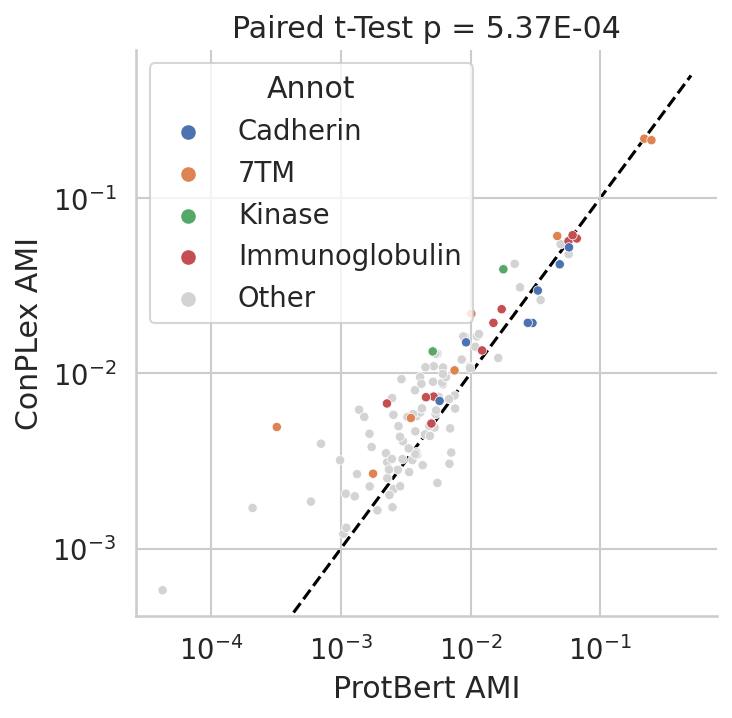

In [113]:
cluster_gmm_sorted['Annot'] = [assign(d) for d in cluster_gmm_sorted['DomName']]
tstat, tp = ttest_rel(cluster_gmm_res['ConPLex'],cluster_gmm_res['ProtBert'],alternative='greater')

plt.figure(figsize=(5, 5), dpi=150)
sns.set(font_scale=1.2,style='whitegrid')
plt.plot([-0.01, 0.5],[-0.01,0.5],linestyle='--',c='black',zorder=0)
sns.scatterplot(data=cluster_gmm_sorted.sort_values(by='Annot',ascending=False),
                x='ProtBert',y='ConPLex',
                hue=cluster_gmm_sorted.sort_values(by='Annot',ascending=False)['Annot'],palette=pal_map,
                hue_order=['Cadherin', '7TM', 'Kinase', 'Immunoglobulin', 'Other'],
                s=20,
               )
plt.xlabel('ProtBert AMI')
plt.ylabel('ConPLex AMI')
plt.loglog()
plt.title(f'Paired t-Test p = {tp:.2E}')
sns.despine()
plt.savefig('../img/surfaceome/surfaceome_scatter_silhouette.svg',bbox_inches='tight')
plt.show()

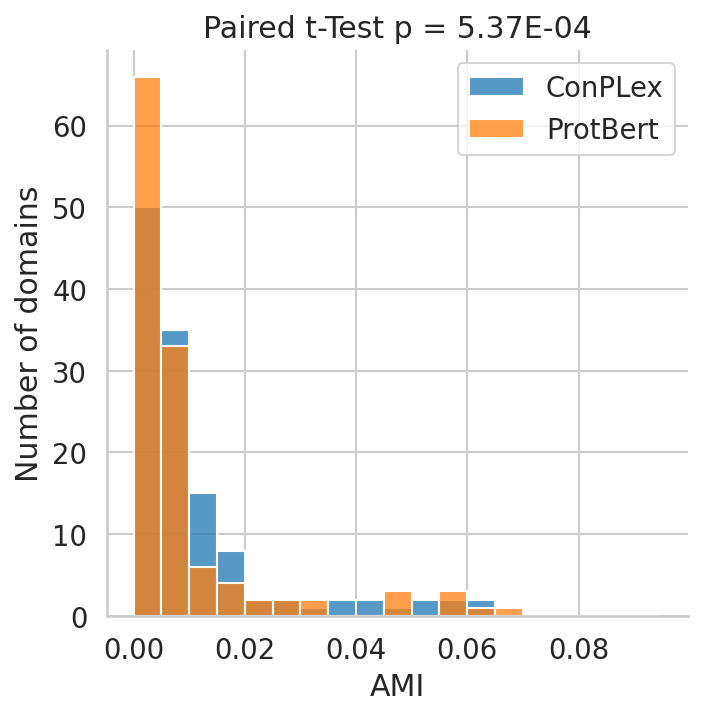

In [112]:
tstat, tp = ttest_rel(cluster_gmm_res['ConPLex'],cluster_gmm_res['ProtBert'],alternative='greater')

plt.figure(figsize=(5, 5), dpi=150)
sns.set(font_scale=1.2,style='whitegrid')
sns.histplot(cluster_gmm_res['ConPLex'],bins=np.arange(0,0.1,0.005),color=sns.color_palette('tab10')[0],label='ConPLex')
sns.histplot(cluster_gmm_res['ProtBert'],bins=np.arange(0,0.1,0.005),color=sns.color_palette('tab10')[1],label='ProtBert')
# plt.axvline(0,linestyle='--',linewidth=5,c='black')
plt.xlabel('AMI')
plt.ylabel('Number of domains')
plt.title(f'Paired t-Test p = {tp:.2E}')
plt.legend()
sns.despine()
plt.savefig('../img/surfaceome/surfaceome_histogram_silhouette.svg',bbox_inches='tight')
plt.show()

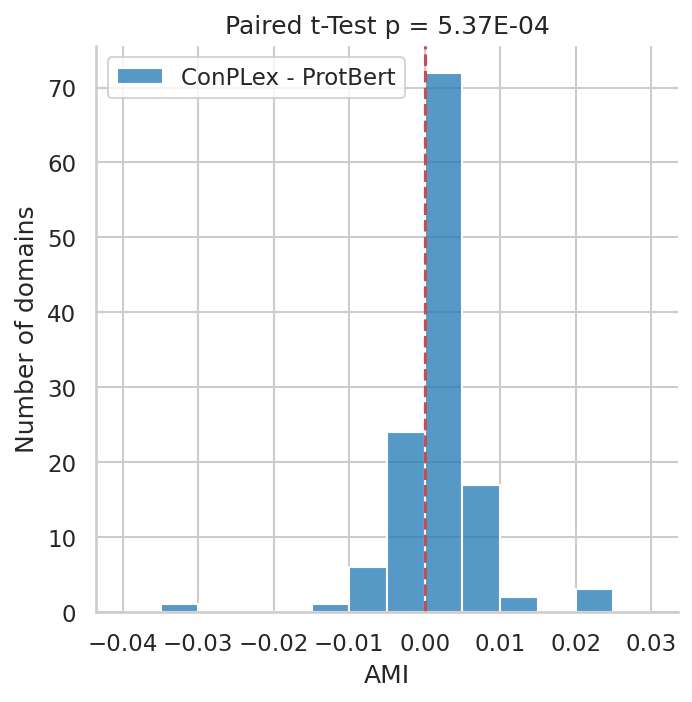

In [109]:
plt.figure(figsize=(5, 5), dpi=150)
sns.set(font_scale=1,style='whitegrid')
sns.histplot(cluster_gmm_res['Residual'],bins=np.arange(-0.04,0.03,0.005),color=sns.color_palette('tab10')[0],label='ConPLex - ProtBert')
plt.axvline(0,c='r',linestyle='--')
plt.xlabel('AMI')
plt.ylabel('Number of domains')
plt.title(f'Paired t-Test p = {tp:.2E}')
plt.legend()
sns.despine()
plt.savefig('../img/surfaceome/surfaceome_residual_histogram_silhouette.svg',bbox_inches='tight')
plt.show()

In [824]:
cluster_gmm_sorted.head(10)

,Domain,Size,CON-Plex,ProtBert,Residual,DomAccession,DomName,Annot
0,PF00069.26,68,0.039300,0.017653,0.021647,PF00069.26,Pkinase,Kinase
1,PF07714.18,68,0.039300,0.017653,0.021647,PF07714.18,PK_Tyr_Ser-Thr,Kinase
2,PF00041.22,103,0.041211,0.021556,0.019655,PF00041.22,fn3,Other
3,PF10320.10,239,0.060763,0.046671,0.014092,PF10320.10,7TM_GPCR_Srsx,7TM
4,PF10328.10,84,0.021894,0.010196,0.011698,PF10328.10,7TM_GPCR_Srx,7TM
5,PF00536.31,14,0.013329,0.005082,0.008247,PF00536.31,SAM_1,Other
6,PF01404.20,14,0.013329,0.005082,0.008247,PF01404.20,Ephrin_lbd,Kinase
7,PF14575.7,14,0.013329,0.005082,0.008247,PF14575.7,EphA2_TM,Kinase
8,PF07647.18,15,0.012918,0.005341,0.007577,PF07647.18,SAM_2,Other
9,PF13306.7,52,0.012899,0.006027,0.006872,PF13306.7,LRR_5,Other


In [826]:
cluster_gmm_sorted.tail(10)

,Domain,Size,CON-Plex,ProtBert,Residual,DomAccession,DomName,Annot
116,PF01839.24,19,0.003040,0.006760,-0.003720,PF01839.24,FG-GAP,Other
117,PF00028.18,114,0.052496,0.056565,-0.004069,PF00028.18,Cadherin,Cadherin
118,PF00083.25,45,0.012163,0.016375,-0.004211,PF00083.25,Sugar_tr,Other
119,PF08266.13,89,0.041968,0.047992,-0.006024,PF08266.13,Cadherin_2,Cadherin
120,PF07690.17,94,0.026774,0.034174,-0.007400,PF07690.17,MFS_1,Other
121,PF15974.6,37,0.019463,0.027277,-0.007814,PF15974.6,Cadherin_tail,Cadherin
122,PF00047.26,265,0.057559,0.065828,-0.008269,PF00047.26,ig,Immunoglobulin
123,PF07686.18,230,0.047298,0.057215,-0.009917,PF07686.18,V-set,Other
124,PF16492.6,40,0.019307,0.029642,-0.010335,PF16492.6,Cadherin_C_2,Cadherin
125,PF13853.7,445,0.214263,0.247928,-0.033665,PF13853.7,7tm_4,7TM


In [828]:
cluster_gmm_sorted[cluster_gmm_sorted['DomName'].str.contains('Cadherin')]

,Domain,Size,CON-Plex,ProtBert,Residual,DomAccession,DomName,Annot
14,PF01049.18,24,0.015075,0.009095,0.005980,PF01049.18,Cadherin_C,Cadherin
61,PF08758.12,14,0.006983,0.005707,0.001277,PF08758.12,Cadherin_pro,Cadherin
113,PF16184.6,67,0.029711,0.032598,-0.002887,PF16184.6,Cadherin_3,Cadherin
117,PF00028.18,114,0.052496,0.056565,-0.004069,PF00028.18,Cadherin,Cadherin
119,PF08266.13,89,0.041968,0.047992,-0.006024,PF08266.13,Cadherin_2,Cadherin
121,PF15974.6,37,0.019463,0.027277,-0.007814,PF15974.6,Cadherin_tail,Cadherin
124,PF16492.6,40,0.019307,0.029642,-0.010335,PF16492.6,Cadherin_C_2,Cadherin


## Silhouette Scores (unsupervised)

In [275]:
do_plot_each = False

silscores = []
protscores = []

pal = [sns.color_palette("colorblind")[i] for i in [7,1]]
for domn in tqdm(domsrted.index[:n_domains]):
    labels = get_pfd_code(domn)
    silscore = silhouette_score(prot_projections, labels, metric='cosine')
    silprot = silhouette_score(protbert_np, labels, metric='cosine')
    
    silscores.append(silscore)
    # tsnescores.append(siltsne)
    # randscores.append(silrand)
    protscores.append(silprot)
    
    if do_plot_each:
        plt.figure(figsize=(3, 3), dpi=80)
        sns.scatterplot(
                        x=embed_tsne[:prot_projections.shape[0],0],
                        y=embed_tsne[:prot_projections.shape[0],1],
                        hue=get_pfd_code(domn),
                        s=5,
                        alpha=1,
                        palette = pal,
                       )
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.title(f"Has {domn} domain (sil {silscore:3f}, siltsne {siltsne:3f}, silrand {silrand:3f})")
        sns.despine()
        plt.show()

  0%|          | 0/126 [00:00<?, ?it/s]

In [276]:
from scipy.stats import ttest_rel

In [277]:
tstat, tp = ttest_rel(silscores,protscores,alternative='greater')

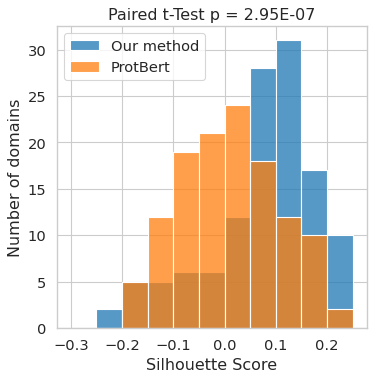

In [325]:
plt.figure(figsize=(5, 5), dpi=80)
sns.set(font_scale=1.2,style='whitegrid')
sns.histplot(silscores,bins=np.arange(-0.3,0.3,0.05),color=sns.color_palette('tab10')[0],label='Our method')
sns.histplot(protscores,bins=np.arange(-0.3,0.3,0.05),color=sns.color_palette('tab10')[1],label='ProtBert')
# plt.axvline(0,linestyle='--',linewidth=5,c='black')
plt.xlabel('Silhouette Score')
plt.ylabel('Number of domains')
plt.title(f'Paired t-Test p = {tp:.2E}')
plt.legend()
plt.show()

In [279]:
domain_silhouette_df = pd.DataFrame({
    'Domain': np.concatenate([domsrted.index[:n_domains],domsrted.index[:n_domains]]),
    'Silhouette Score': np.concatenate([silscores[:n_domains],protscores[:n_domains]]),
    'Embedding Method': ['CON-Plex']*n_domains + ['ProtBert']*n_domains,
})

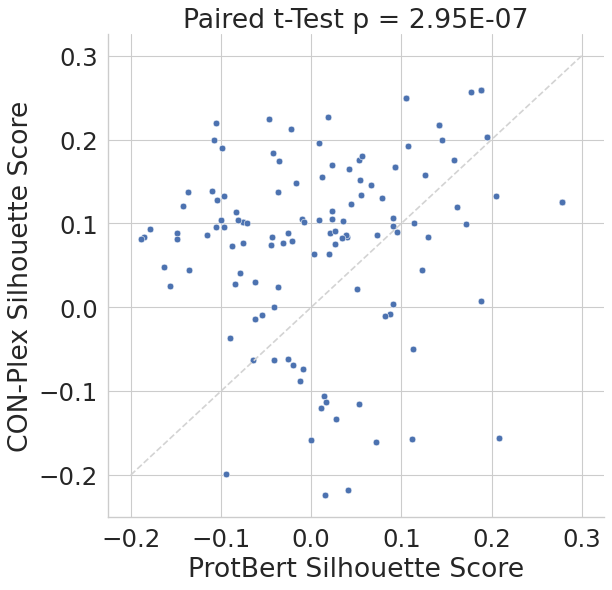

In [323]:
sns.set(style='whitegrid',font_scale=2)
plt.figure(figsize=(8, 8), dpi=80)

domain_silhouette_piv = domain_silhouette_df.pivot(['Domain'], ['Embedding Method'], ['Silhouette Score'])
domain_silhouette_piv.columns=['CON-Plex','ProtBert']

sns.scatterplot(data=domain_silhouette_piv,x='ProtBert',y='CON-Plex')
plt.xlabel('ProtBert Silhouette Score')
plt.ylabel('CON-Plex Silhouette Score')
plt.title(f'Paired t-Test p = {tp:.2E}')
plt.plot([-0.2, 0.3],[-0.2,0.3],linestyle='--',c='lightgrey')
sns.despine()
# plt.savefig(f'../img/surfaceome_pfam_silhouettes_boxplot.svg',bbox_inches='tight')
plt.show()

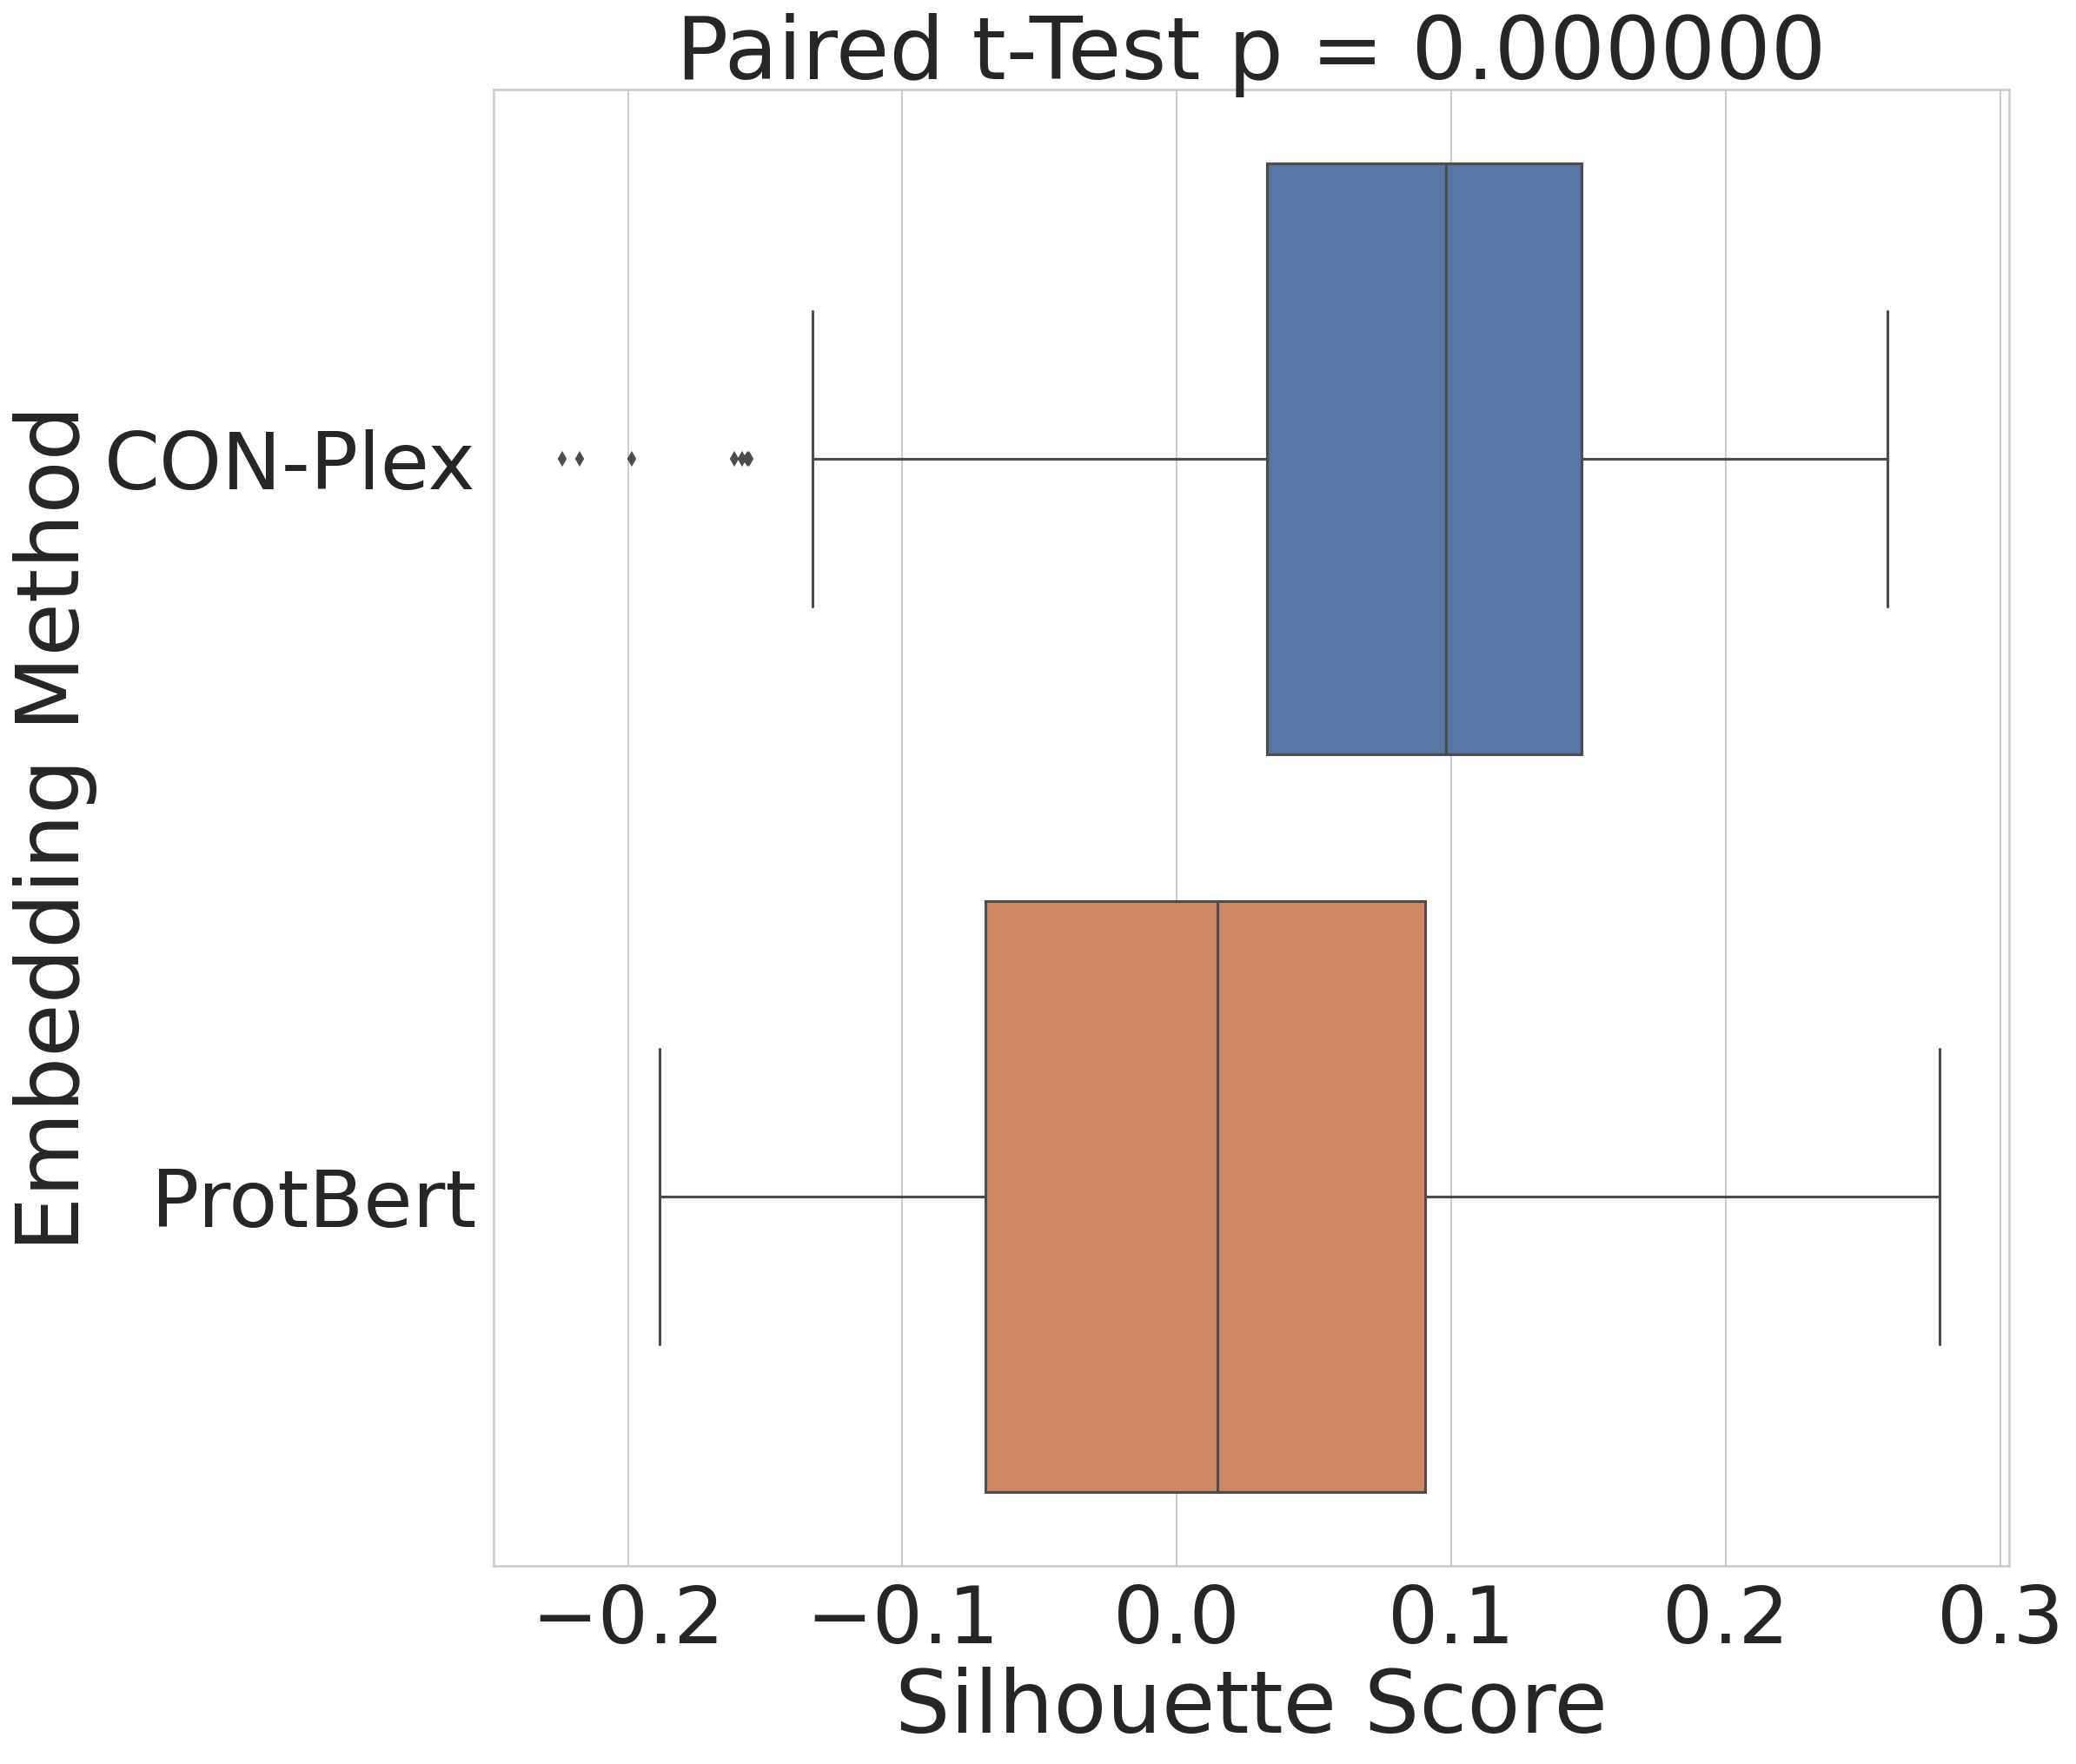

In [280]:
sns.set(style='whitegrid',font_scale=4)
plt.figure(figsize=(15, 15), dpi=150)

sns.boxplot(data=domain_silhouette_df,x='Silhouette Score',y='Embedding Method')
# plt.ylabel('Silhouette Score')
# plt.xlabel('Embedding Method')
plt.title(f'Paired t-Test p = {tp:4f}')
# plt.savefig(f'../img/surfaceome_pfam_silhouettes_boxplot.svg',bbox_inches='tight')
plt.show()

In [281]:
topk_domain_silhouette_df = domain_silhouette_df[domain_silhouette_df['Domain'].isin(domsrted[domsrted > 25].index)]

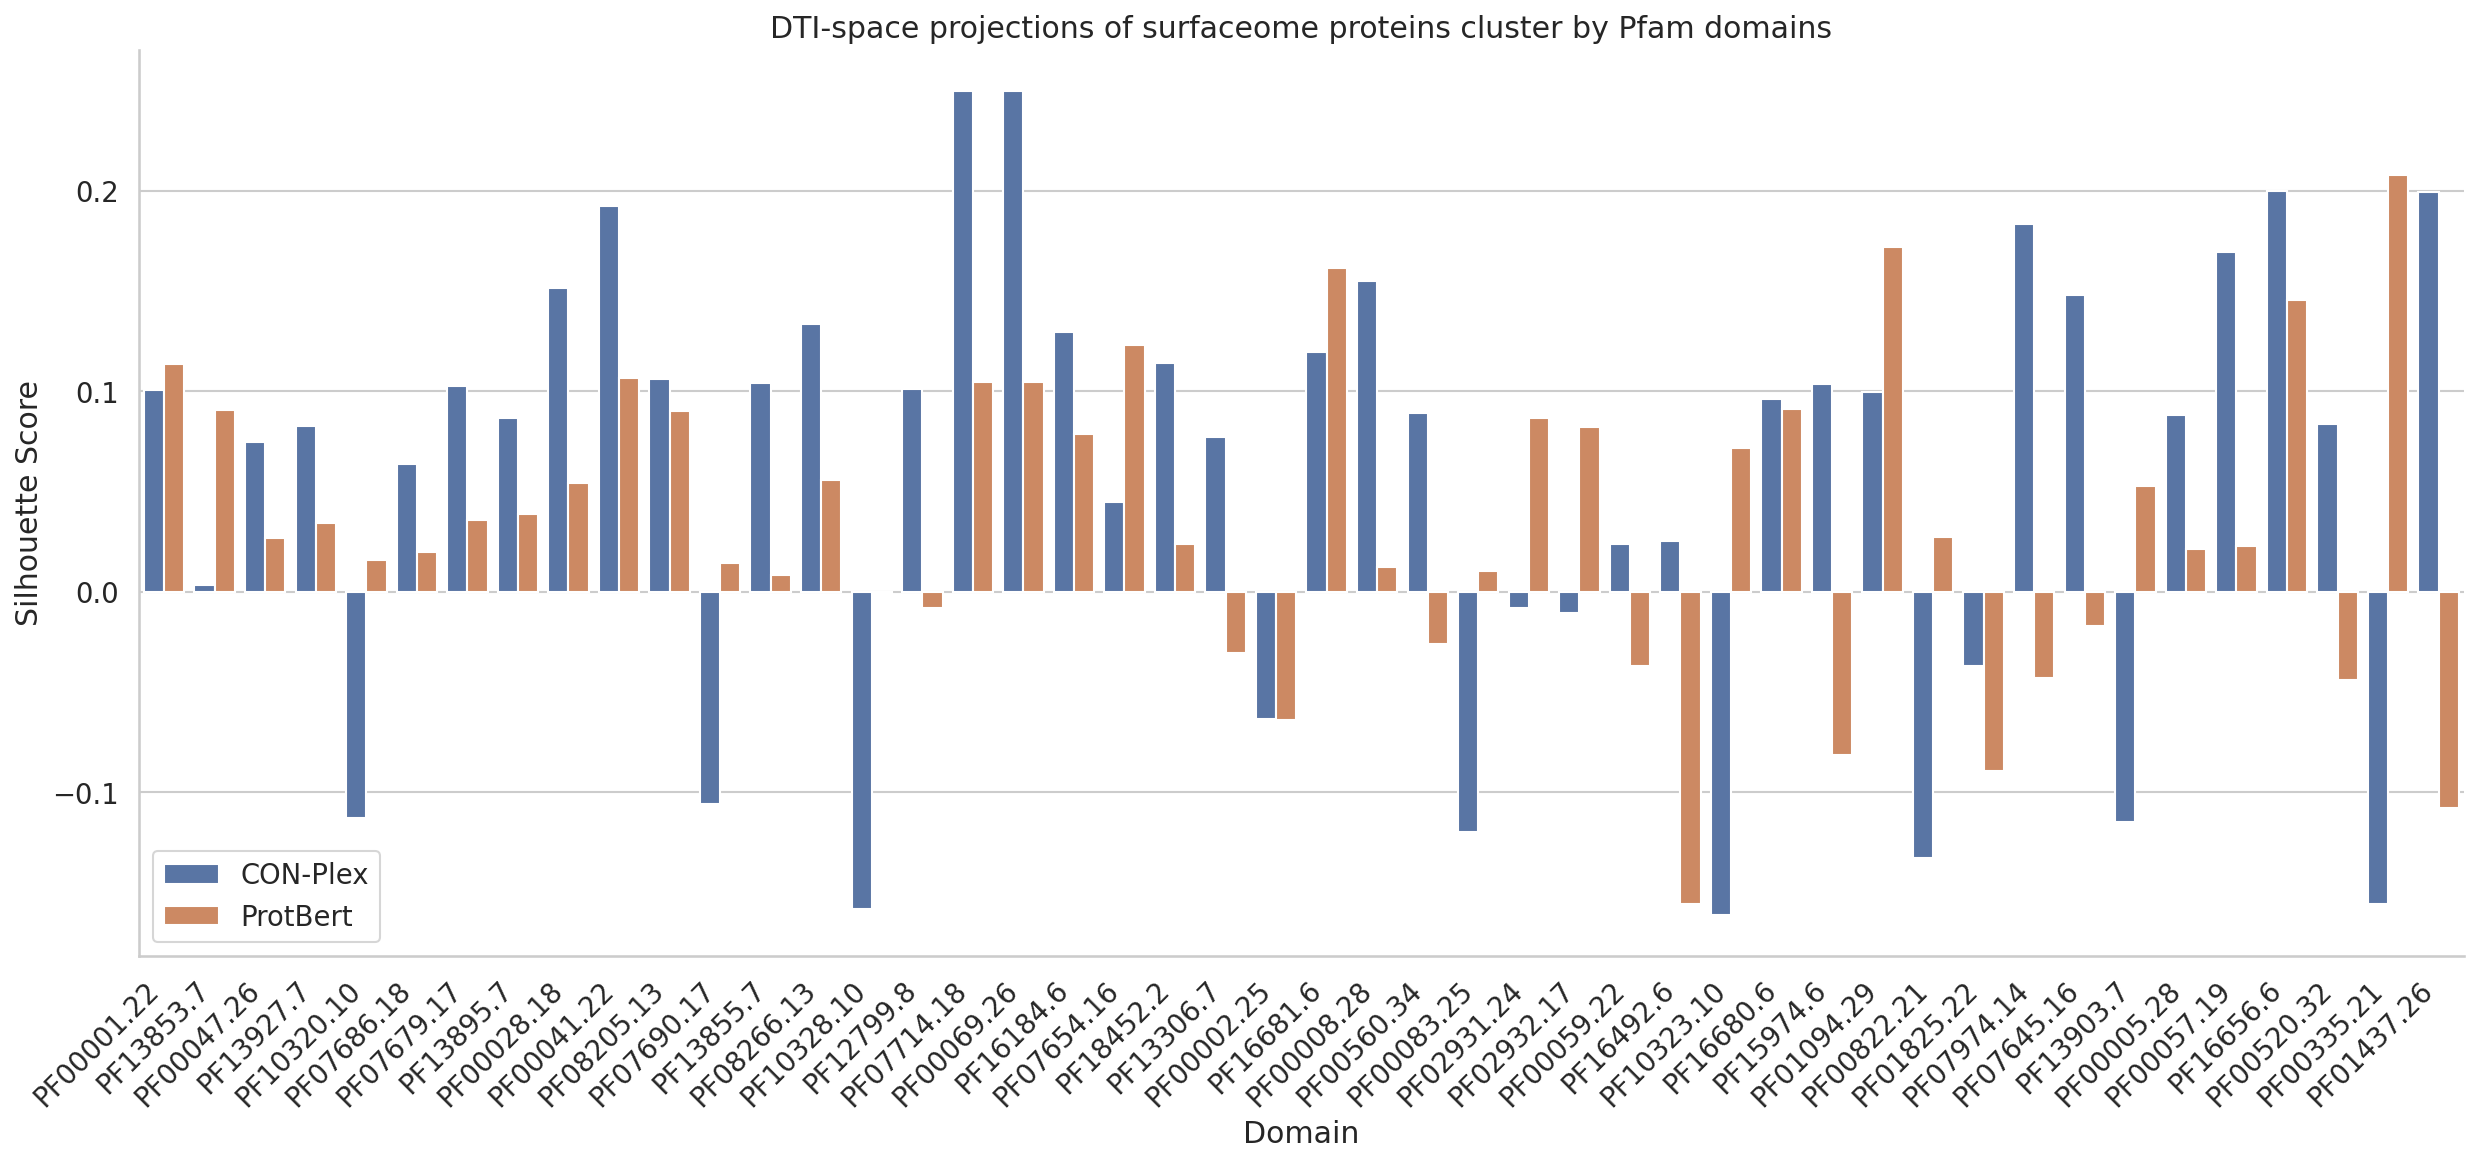

In [282]:
plt.figure(figsize=(20, 8), dpi=150)
sns.set(font_scale=1.2,style='whitegrid')

sns.barplot(data=topk_domain_silhouette_df,x='Domain',y='Silhouette Score',hue='Embedding Method')
# plt.xlabel('Pfam domain')
# plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.title('DTI-space projections of surfaceome proteins cluster by Pfam domains')
plt.legend(loc='lower left')
sns.despine()
# plt.savefig(f'../img/surfaceome_pfam_silhouettes_barplot.svg',bbox_inches='tight')
plt.show()

In [478]:
domain_pivot = topk_domain_silhouette_df.pivot(['Domain'],['Embedding Method'])
domain_pivot[('Silhouette Score','Difference')] = domain_pivot[('Silhouette Score','CON-Plex')] - domain_pivot[('Silhouette Score','ProtBert')]
domain_pivot = domain_pivot.reset_index().sort_values(by=('Silhouette Score','Difference'), ascending=False)
pd.merge(domain_pivot, dom_name_key, left_on='Domain', right_on='DomAccession')

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  after removing the cwd from sys.path.


,"(Domain, )","(Silhouette Score, CON-Plex)","(Silhouette Score, ProtBert)","(Silhouette Score, Difference)",DomAccession,DomName
0,PF01437.26,0.199702,-0.107828,0.307529,PF01437.26,PSI
1,PF07974.14,0.183777,-0.042734,0.226511,PF07974.14,EGF_2
2,PF15974.6,0.103807,-0.081215,0.185022,PF15974.6,Cadherin_tail
3,PF16492.6,0.025264,-0.155984,0.181248,PF16492.6,Cadherin_C_2
4,PF07645.16,0.148135,-0.016917,0.165051,PF07645.16,EGF_CA
5,PF00057.19,0.169436,0.022943,0.146493,PF00057.19,Ldl_recept_a
6,PF07714.18,0.249729,0.104806,0.144923,PF07714.18,PK_Tyr_Ser-Thr
7,PF00069.26,0.249729,0.104806,0.144923,PF00069.26,Pkinase
8,PF00008.28,0.154974,0.012244,0.142729,PF00008.28,EGF
9,PF00520.32,0.083652,-0.043943,0.127595,PF00520.32,Ion_trans


In [173]:
poor_domains = topk_domain_silhouette_df[(topk_domain_silhouette_df['Embedding Method'] == 'CON-Plex') & (topk_domain_silhouette_df['Silhouette Score'] < -0.05)]
poor_domains_mrg = pd.merge(poor_domains, dom_name_key, left_on='Domain', right_on='DomAccession')[['DomAccession','DomName','Silhouette Score']].sort_values(by='Silhouette Score')
poor_domains_mrg

,DomAccession,DomName,Silhouette Score
5,PF10323.10,7TM_GPCR_Srv,-0.161232
2,PF10328.10,7TM_GPCR_Srx,-0.158273
8,PF00335.21,Tetraspanin,-0.155724
6,PF00822.21,PMP22_Claudin,-0.132874
4,PF00083.25,Sugar_tr,-0.119794
7,PF13903.7,Claudin_2,-0.114846
0,PF10320.10,7TM_GPCR_Srsx,-0.112911
1,PF07690.17,MFS_1,-0.105771
3,PF00002.25,7tm_2,-0.063227


In [176]:
good_domains = topk_domain_silhouette_df[(domain_silhouette_df['Embedding Method'] == 'CON-Plex') & (domain_silhouette_df['Silhouette Score'] > 0.1)]
good_domains_mrg = pd.merge(good_domains, dom_name_key, left_on='Domain', right_on='DomAccession')[['DomAccession','DomName','Silhouette Score']].sort_values(by='Silhouette Score',ascending=False)
good_domains_mrg

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,DomAccession,DomName,Silhouette Score
8,PF07714.18,PK_Tyr_Ser-Thr,0.249729
9,PF00069.26,Pkinase,0.249729
18,PF16656.6,Pur_ac_phosph_N,0.199935
19,PF01437.26,PSI,0.199702
3,PF00041.22,fn3,0.192468
15,PF07974.14,EGF_2,0.183777
17,PF00057.19,Ldl_recept_a,0.169436
13,PF00008.28,EGF,0.154974
2,PF00028.18,Cadherin,0.151819
16,PF07645.16,EGF_CA,0.148135


---

## Classify Unclassified Targets

In [390]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

In [391]:
class_names = ['Transporters','Miscellaneous','Receptors','Enzymes']

In [392]:
# unk_names = ['Unclassified',
#  'Unknown_function;CSMD',
#  'Unknown_function;IG_Unknown_function',
#  'Unknown_function;ITM2',
#  'Unknown_function;LHFP',
#  'Unknown_function;LRRC37',
#  'Unknown_function;MS4A',
#  'Unknown_function;RNFT',
#  'Unknown_function;TM9SF',
#  'Unknown_function;TMEM132',
#  'Unknown_function;TMEM16',
#  'Unknown_function;TMEM30',
#  'Unknown_function;TMEM63',
#  'Unknown_function;TetraspaninL6']
# class_names = [i for i in set(almen_minor) if (i not in unk_names)][1:]

In [393]:
classified_targets = [pn for (pn,ac) in zip(prot_names, almen_class) if ac in class_names]
classified_labels = [ac for ac in almen_class if ac in class_names]
classified_projections = np.stack([pj for (pj,ac) in zip(prot_projections, almen_class) if ac in class_names])
classified_protbert = np.stack([pj for (pj,ac) in zip(protbert_np, almen_class) if ac in class_names])

unclassified_targets = [pn for (pn,ac) in zip(prot_names, almen_class) if ac not in class_names]
unclassified_projections = np.stack([pj for (pj,ac) in zip(prot_projections, almen_class) if ac not in class_names])
unclassified_protbert = np.stack([pj for (pj,ac) in zip(protbert_np, almen_class) if ac not in class_names])

In [394]:
len(classified_targets), len(unclassified_targets)

(2128, 588)

In [395]:
# classified_targets = [pn for (pn,ac) in zip(prot_names, almen_minor) if ac in class_names]
# classified_labels = [ac for ac in almen_minor if ac in class_names]
# classified_projections = np.stack([pj for (pj,ac) in zip(prot_projections, almen_minor) if ac in class_names])

# unclassified_targets = [pn for (pn,ac) in zip(prot_names, almen_minor) if ac not in class_names]
# unclassified_projections = np.stack([pj for (pj,ac) in zip(prot_projections, almen_minor) if ac not in class_names])

In [396]:
accs = []
acc_pb = []
aris = []
ari_pb = []

for k in np.arange(1,51):
    knn_cv = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    cv_score = cross_validate(knn_cv, 
                   X = classified_projections, 
                   y = classified_labels, 
                   scoring = ('accuracy','balanced_accuracy','adjusted_rand_score')
                  )
    cv_pb = cross_validate(knn_cv, 
                   X = classified_protbert, 
                   y = classified_labels, 
                   scoring = ('accuracy','balanced_accuracy','adjusted_rand_score')
                  )
    accs.append(cv_score['test_accuracy'].mean())
    acc_pb.append(cv_pb['test_accuracy'].mean())
    aris.append(cv_score['test_adjusted_rand_score'].mean())
    ari_pb.append(cv_pb['test_adjusted_rand_score'].mean())
    # print(k, cv_score['test_accuracy'].mean(), cv_score['test_adjusted_rand_score'].mean())

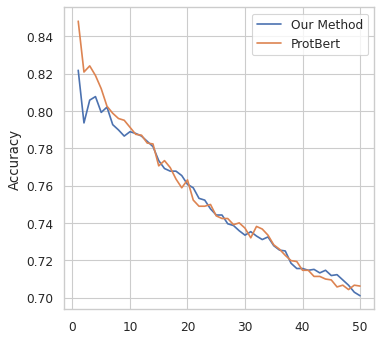

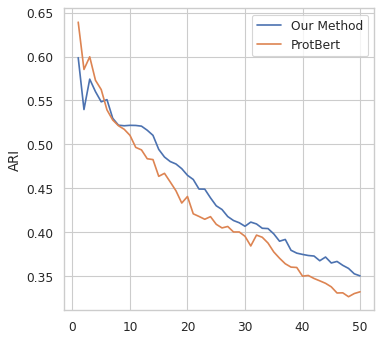

In [397]:
plt.figure(figsize=(5, 5), dpi=80)
sns.set(font_scale=1,style='whitegrid')
plt.plot(np.arange(1,51), accs, label='Our Method')
plt.plot(np.arange(1,51), acc_pb, label='ProtBert')
plt.legend()
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(5, 5), dpi=80)
sns.set(font_scale=1,style='whitegrid')
plt.plot(np.arange(1,51), aris, label='Our Method')
plt.plot(np.arange(1,51), ari_pb, label='ProtBert')
plt.legend()
plt.ylabel('ARI')
plt.show()

In [400]:
knn_class = KNeighborsClassifier(n_neighbors=5, metric="cosine")
knn_class.fit(classified_projections, classified_labels)

KNeighborsClassifier(metric='cosine')

In [401]:
known_or_not = []
new_ac = []
new_sizes = []
for ac, pp in zip(almen_class, prot_projections):
    if ac not in class_names:
        new_ac.append(knn_class.predict(pp.reshape(1, -1))[0])
        known_or_not.append("Unclassified")
        new_sizes.append(100)
    else:
        new_ac.append(ac)
        known_or_not.append(ac)
        new_sizes.append(20)

In [408]:
predictions = []
for (tn, pp) in zip(unclassified_targets, unclassified_projections):
    predictions.append(knn_class.predict(pp.reshape(1, -1))[0])

In [411]:
pd.DataFrame(predictions, unclassified_targets, )

,0
A0FGR9,Receptors
A2RRL7,Miscellaneous
A2VDJ0,Receptors
A6NC51,Receptors
A6ND01,Receptors
...,...
Q9Y625,Miscellaneous
Q9Y639,Miscellaneous
Q9Y6F6,Receptors
Q9Y6M0,Receptors


In [402]:
tab10_blue = sns.color_palette('tab10')[0]
tab10_red = sns.color_palette('tab10')[3]
tab10_green = sns.color_palette('tab10')[2]
tab10_grey = sns.color_palette('tab10')[7]
light_grey = (0.8,0.8,0.8)
palette = {"Transporters": tab10_blue, "Unclassified": light_grey, "Miscellaneous": tab10_grey, "Receptors": tab10_red, "Enzymes": tab10_green}

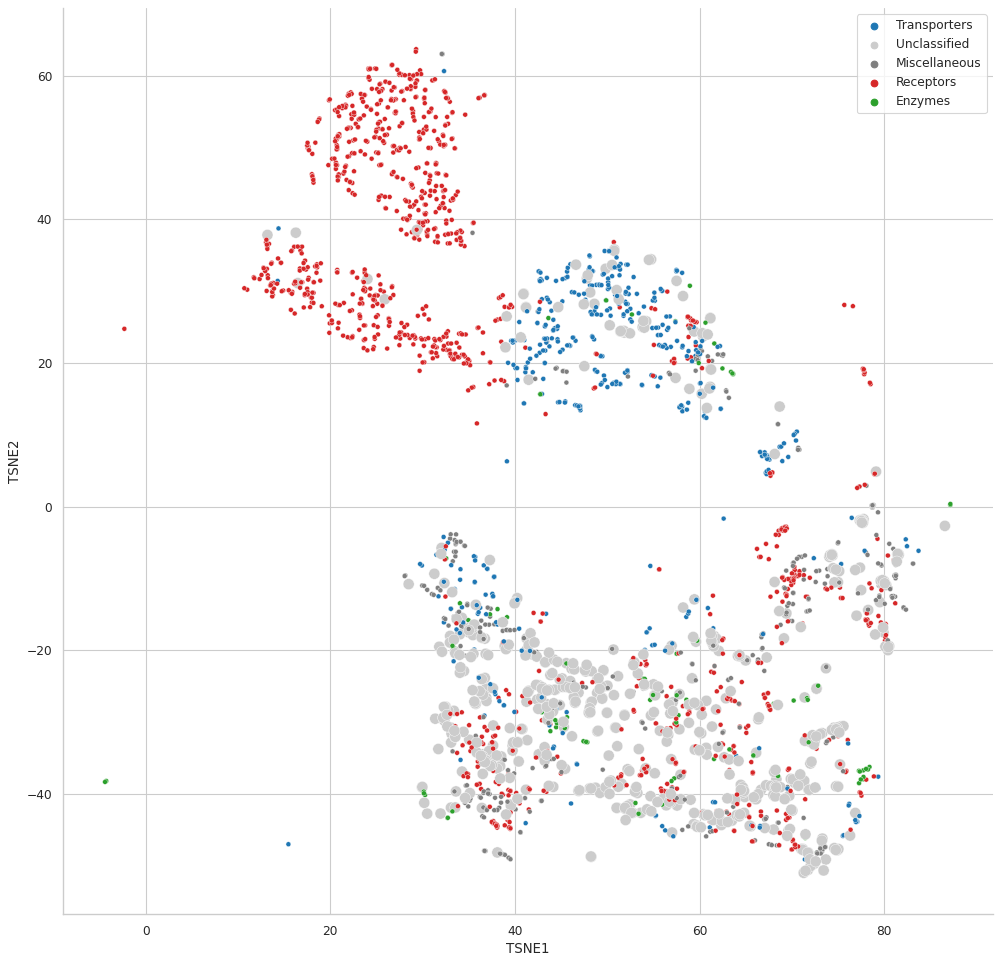

In [403]:
sns.set(style='whitegrid')
style = ['Molecule'] * mol_projections.shape[0]
plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(
                x=embed_tsne[:prot_projections.shape[0],0],
                y=embed_tsne[:prot_projections.shape[0],1],
                hue=known_or_not,
                s=new_sizes,
                alpha=1,
                palette=palette,
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
sns.despine()
plt.show()

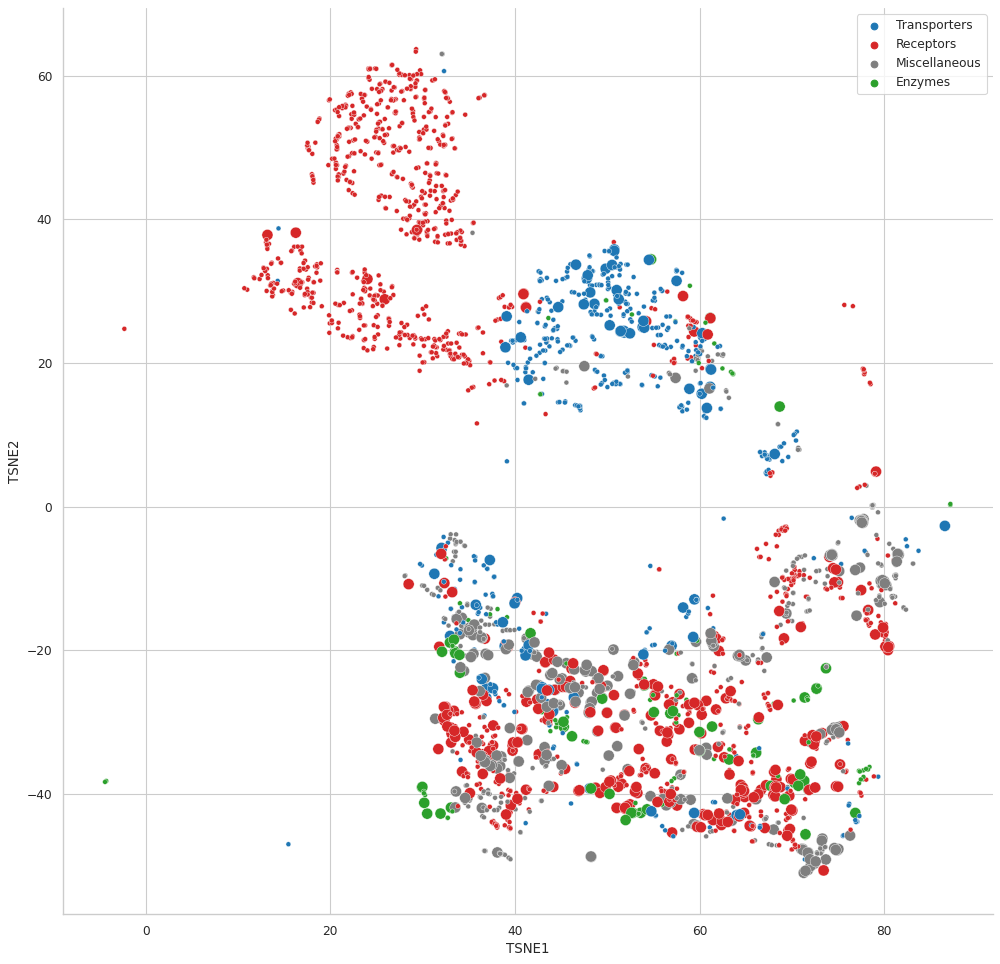

In [404]:
sns.set(style='whitegrid')
style = ['Molecule'] * mol_projections.shape[0]
plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(
                x=embed_tsne[:prot_projections.shape[0],0],
                y=embed_tsne[:prot_projections.shape[0],1],
                hue=new_ac,
                s=new_sizes,
                alpha=1,
                palette=palette,
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
sns.despine()
plt.show()

---
# Pairwise scores

In [ ]:
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine
cosine_sim = CosineSimilarity(dim=0)

pairwise = np.zeros((len(prot_names),len(mol_names)))
predictions = []
for i, (p_name, p_proj) in tqdm(enumerate(zip(prot_names,prot_projections)),total=len(prot_names)):
        p_proj_torch = torch.from_numpy(p_proj)
        for j, (m_name, m_proj) in enumerate(zip(mol_names,mol_projections)):
            with torch.set_grad_enabled(False):
                affin = cosine_sim(p_proj_torch,torch.from_numpy(m_proj)).numpy()
                predictions.append((p_name, m_name, affin))
                pairwise[i,j] = affin

In [ ]:
pred_df = pd.DataFrame(predictions,columns=['Target','Molecule','CosineSim'])
pred_df.head()

In [ ]:
pred_df.shape

In [ ]:
pred_df.to_csv('../nbdata/drugbank_x_surfaceome_classification_2022-07-07.csv',sep=',',header=True,index=False)

In [ ]:
mol_projections[:10]

In [ ]:
mol_names[:10]